In [1]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import bert
# from bert import BertModelLayer
# from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
# from bert.tokenization.bert_tokenization import FullTokenizer
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(font_scale=1.2)
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [2]:
import re
import matplotlib.image as image
import matplotlib.colors
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import squarify as sq
from colorama import Fore, Back, Style

In [3]:
df = pd.read_csv('../data/winemag-data-130k-v2.csv')
print(df['variety'].head(100))

0                  White Blend
1               Portuguese Red
2                   Pinot Gris
3                     Riesling
4                   Pinot Noir
                ...           
95                       Gamay
96                       Gamay
97                    Riesling
98                  Sangiovese
99    Bordeaux-style Red Blend
Name: variety, Length: 100, dtype: object


In [4]:
df.shape

(129971, 14)

In [5]:
df[df.duplicated('description',keep=False)].sort_values('description').head(5)

Unnamed: 0 country                                        description  \
67614        67614      US  100% Malbec, it's redolent with dark plums, wi...   
46540        46540      US  100% Malbec, it's redolent with dark plums, wi...   
119702      119702      US  100% Sangiovese, this pale pink wine has notes...   
72181        72181      US  100% Sangiovese, this pale pink wine has notes...   
73731        73731  France  87-89 Barrel sample. A pleasurable, perfumed w...   

          designation  points  price    province              region_1  \
67614             NaN      87   20.0  Washington     Rattlesnake Hills   
46540             NaN      87   20.0  Washington     Rattlesnake Hills   
119702         Meadow      88   18.0  Washington  Columbia Valley (WA)   
72181          Meadow      88   18.0  Washington  Columbia Valley (WA)   
73731   Barrel sample      88    NaN    Bordeaux          Saint-Julien   

               region_2       taster_name taster_twitter_handle  \
67614   Columbia Valley  Sean P. Sullivan         @wawinereport   
46540   Columbia Valley  Sean P. Sullivan         @wawinereport   
119702  Columbia Valley  Sean P. Sullivan         @wawinereport   
72181   Columbia Valley  Sean P. Sullivan         @wawinereport   
73731               NaN        Roger Voss            @vossroger   

                                                    title  \
67614          Roza Ridge 2010 Malbec (Rattlesnake Hills)   
46540          Roza Ridge 2010 Malbec (Rattlesnake Hills)   
119702  Ross Andrew 2013 Meadow Rosé (Columbia Valley ...   
72181   Ross Andrew 2013 Meadow Rosé (Columbia Valley ...   
73731   Château Lalande-Borie 2008 Barrel sample  (Sai...   

                         variety                 winery  
67614                     Malbec             Roza Ridge  
46540                     Malbec             Roza Ridge  
119702                      Rosé            Ross Andrew  
72181                       Rosé            Ross Andrew  
73731   Bordeaux-style Red Blend  Château Lalande-Borie

In [6]:
# Dropping all duplicates
df.drop_duplicates(('description', 'title'), inplace=True)
df[pd.notnull(df.price)]
df.shape

(119988, 14)

In [7]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.style.background_gradient(cmap='seismic')

In [8]:
# Imputing missing values
for col in ('region_2', 'designation', 'taster_twitter_handle', 'taster_name', 'region_1'):
    df[col]=df[col].fillna('Unknown')
df['province'] = df['province'].fillna(df['province'].mode())
df['price'] = df['price'].fillna(df['price'].mean())

In [9]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [10]:
data = df['country'].replace("US", "United States").value_counts()
iplot([go.Choropleth(
    locationmode='country names',
    locations=data.index.values,
    text=data.index,
    z=data.values,
    colorscale='portland'
)])

In [11]:
df.head()

Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points      price           province  \
0                        Vulkà Bianco      87  35.620747  Sicily & Sardinia   
1                            Avidagos      87  15.000000              Douro   
2                             Unknown      87  14.000000             Oregon   
3                Reserve Late Harvest      87  13.000000           Michigan   
4  Vintner's Reserve Wild Child Block      87  65.000000             Oregon   

              region_1           region_2         taster_name  \
0                 Etna            Unknown       Kerin O’Keefe   
1              Unknown            Unknown          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore            Unknown  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3               Unknown  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [12]:
# Countries with the most wine reviews
countries = df.country.value_counts()
# Limit top countries to those with more than 500 reviews
temp_dict = countries[countries>500].to_dict()
temp_dict['Other'] = countries[countries<501].sum()
less_countries = pd.Series(temp_dict)
less_countries.sort_values(ascending=False, inplace=True)
# Turn Series into DataFrame for display purposes
df1 = less_countries.to_frame()
df1.columns=['Number of Reviews']
df1.index.name = 'Country'
df1.style.background_gradient(cmap='coolwarm')

Text(0.5, 1.0, 'Countries by Number of Wine Reviews')

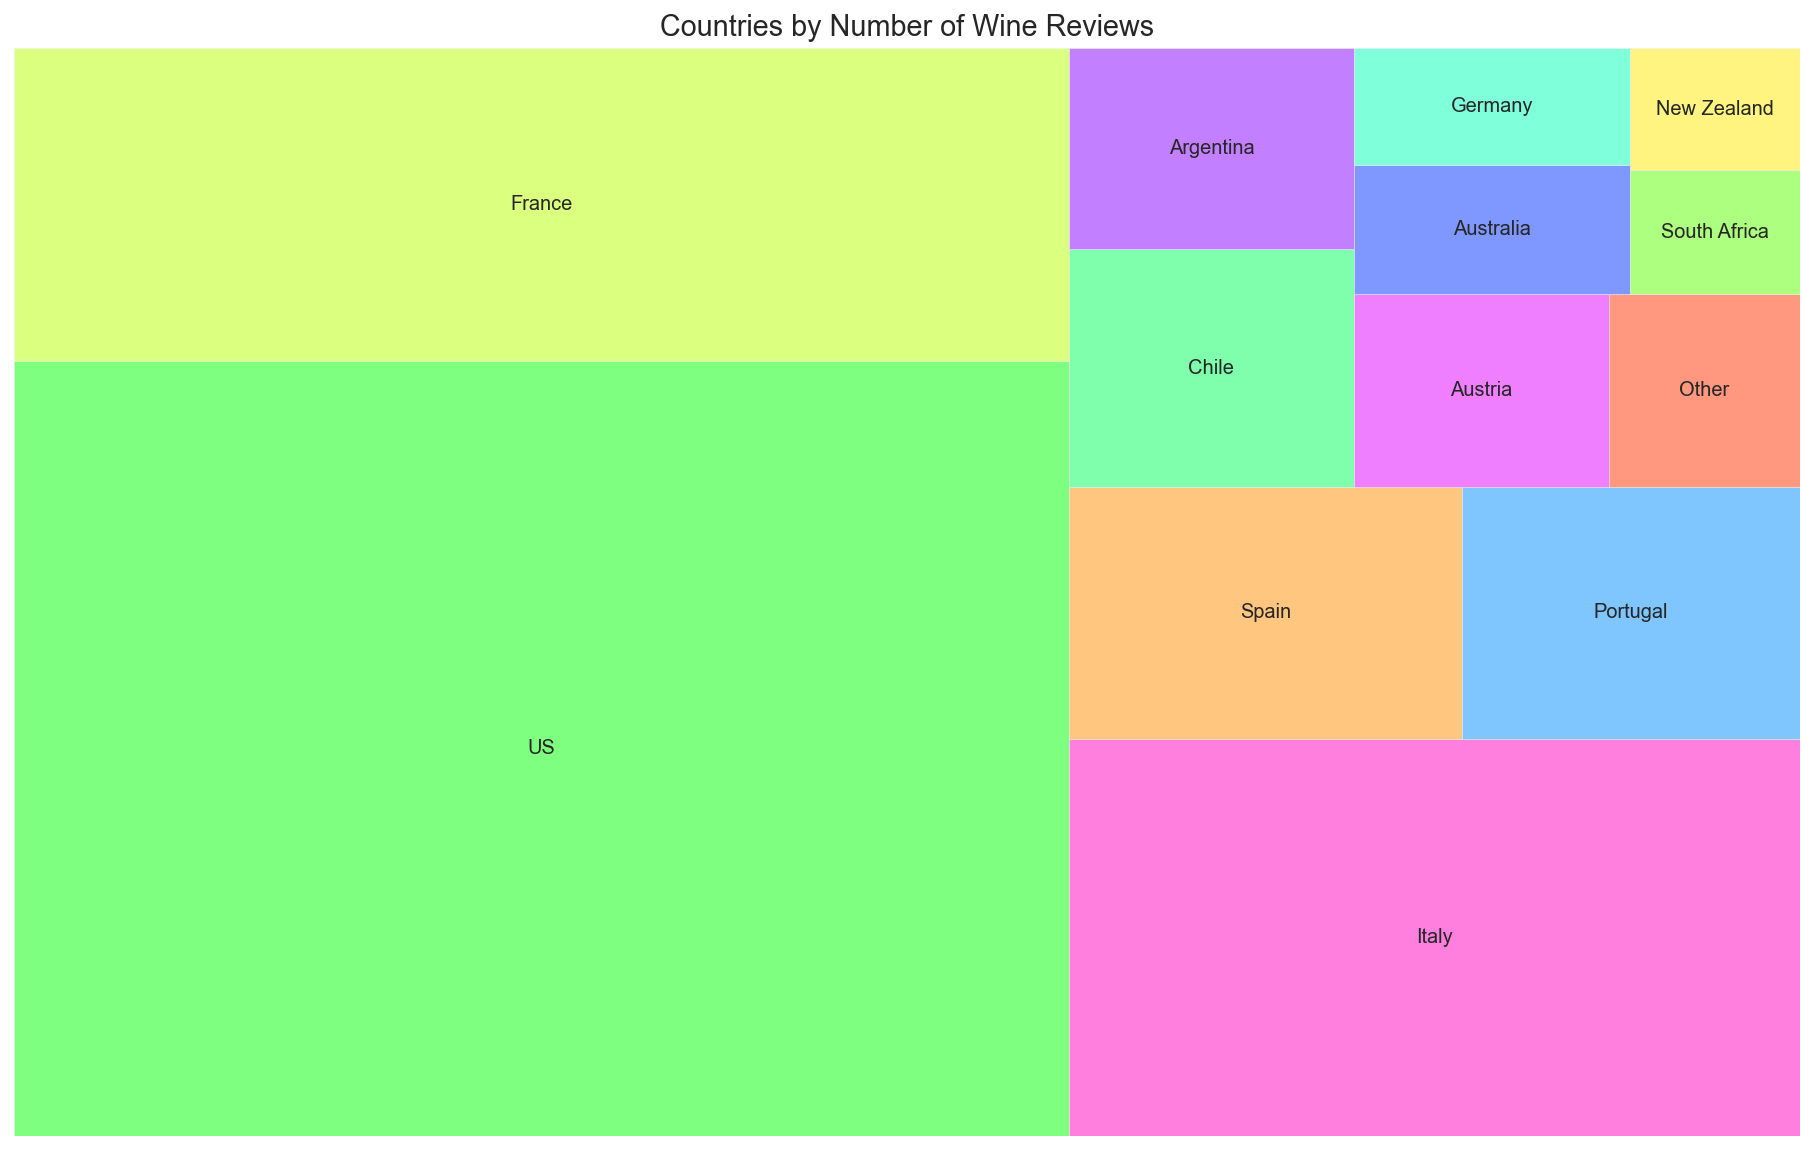

In [13]:
# Tree map 
cmap = plt.cm.gist_rainbow_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=15)
colors = [cmap(norm(value)) for value in range(15)]
np.random.shuffle(colors)
fig,ax = plt.subplots(1,1,figsize=(16, 10))
sq.plot(sizes=less_countries.values, label=less_countries.index.values, alpha=0.5, ax=ax, color=colors)
plt.axis('off')
plt.title('Countries by Number of Wine Reviews')

In [14]:
testDf = df[['points','price']]


<AxesSubplot:>

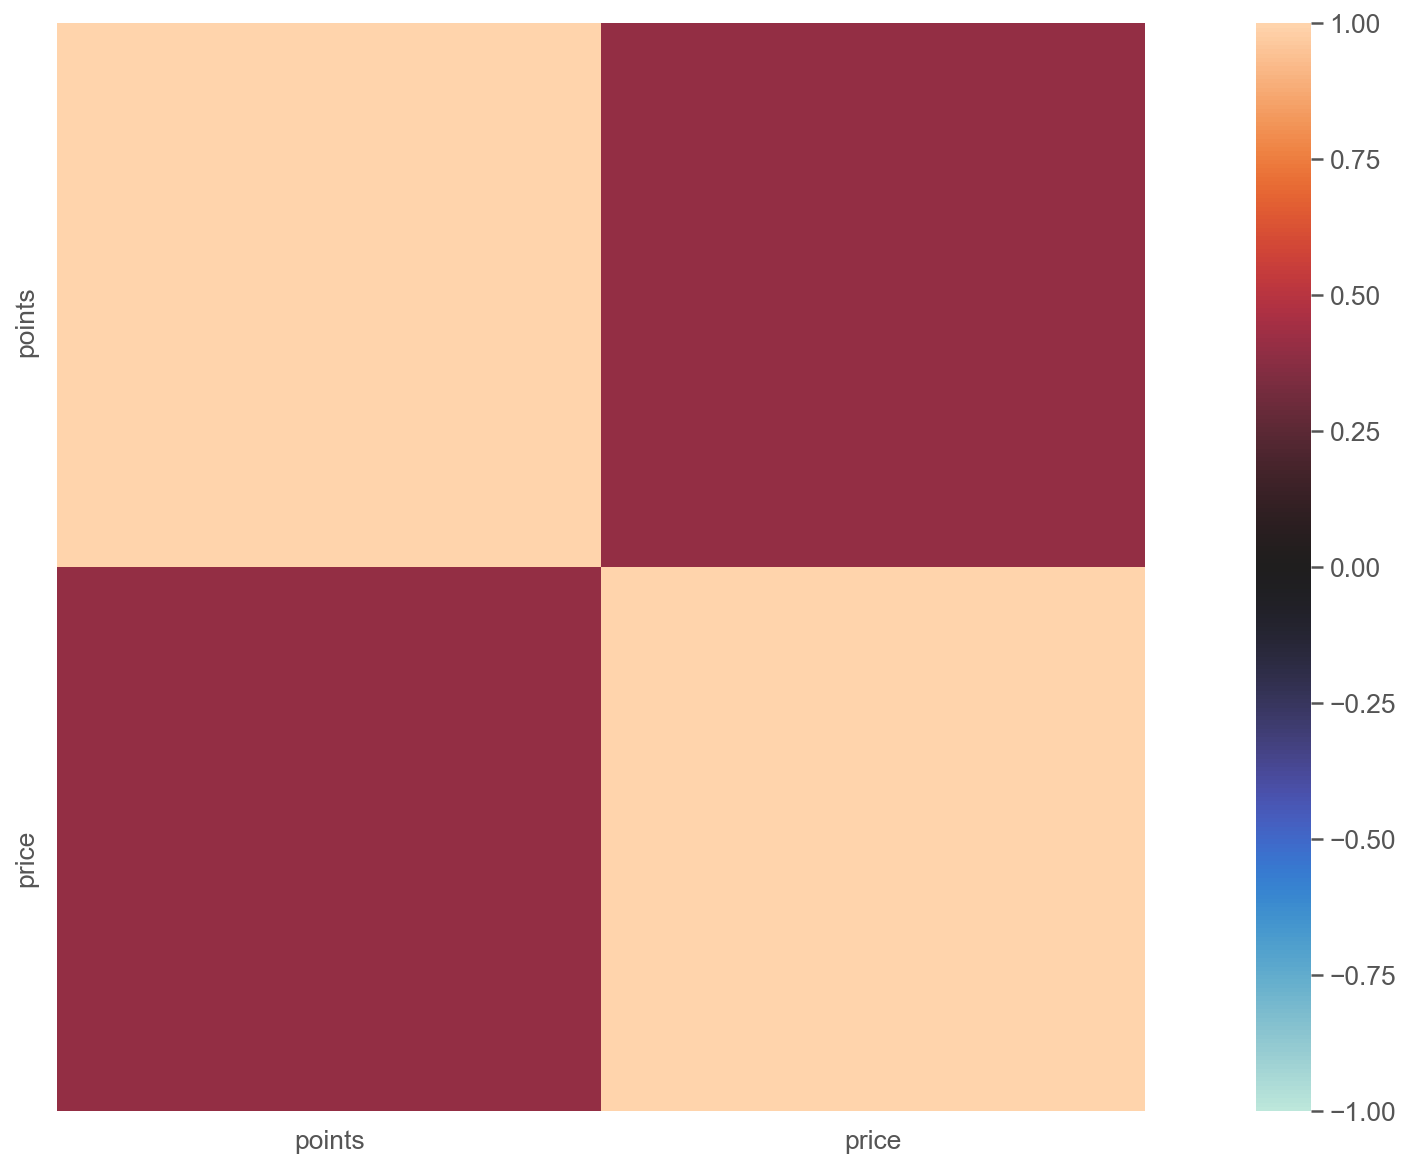

In [15]:
corrmat = testDf.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corrmat,square=True,vmin = -1,vmax = 1,center = 0)

In [16]:
fig = iplot([go.Scatter(x=df.head(10000)['points'],
                  y=df.head(10000)['price'],
                  mode='markers', marker_color='darkred')])

In [17]:
data = df.assign(n=0).groupby(['points', 'price'])['n'].count().reset_index()
data = data[data["price"] < 300]
v = data.pivot(index='price', columns='points', values='n').fillna(0).values.tolist()
iplot([go.Surface(z=v)])

In [18]:
w = df.groupby(['country','points'])['price'].agg(['count','min','max','mean']).sort_values(by='mean',ascending=False)[:10]
w.reset_index(inplace=True)
w.style.background_gradient(cmap='Wistia', high=0.5)


Number of variety of wines 707


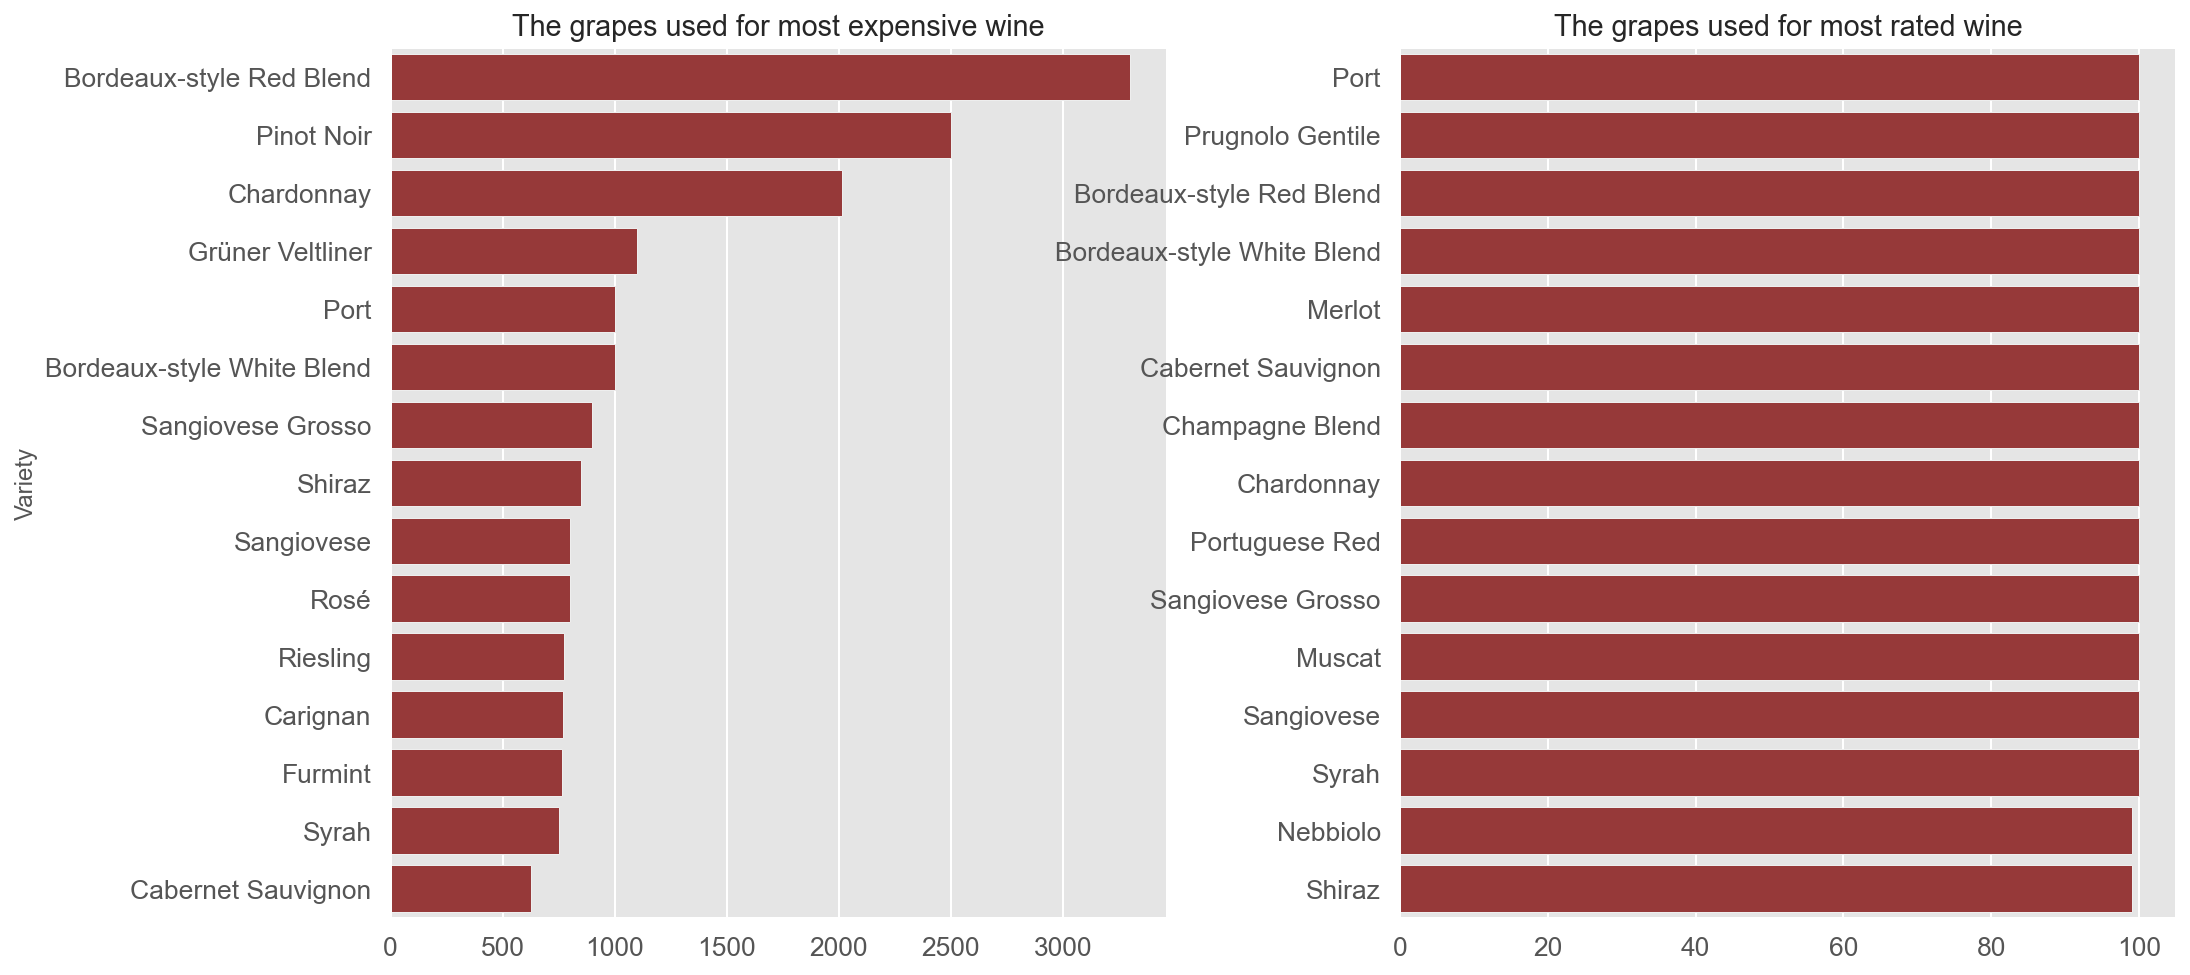

In [19]:
print(Fore.YELLOW + 'Number of variety of wines', df['variety'].nunique())
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['variety'])['price'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='brown',ax=ax1)
ax1.set_title('The grapes used for most expensive wine')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['variety'])['points'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='brown',ax=ax2)
ax2.set_title('The grapes used for most rated wine')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

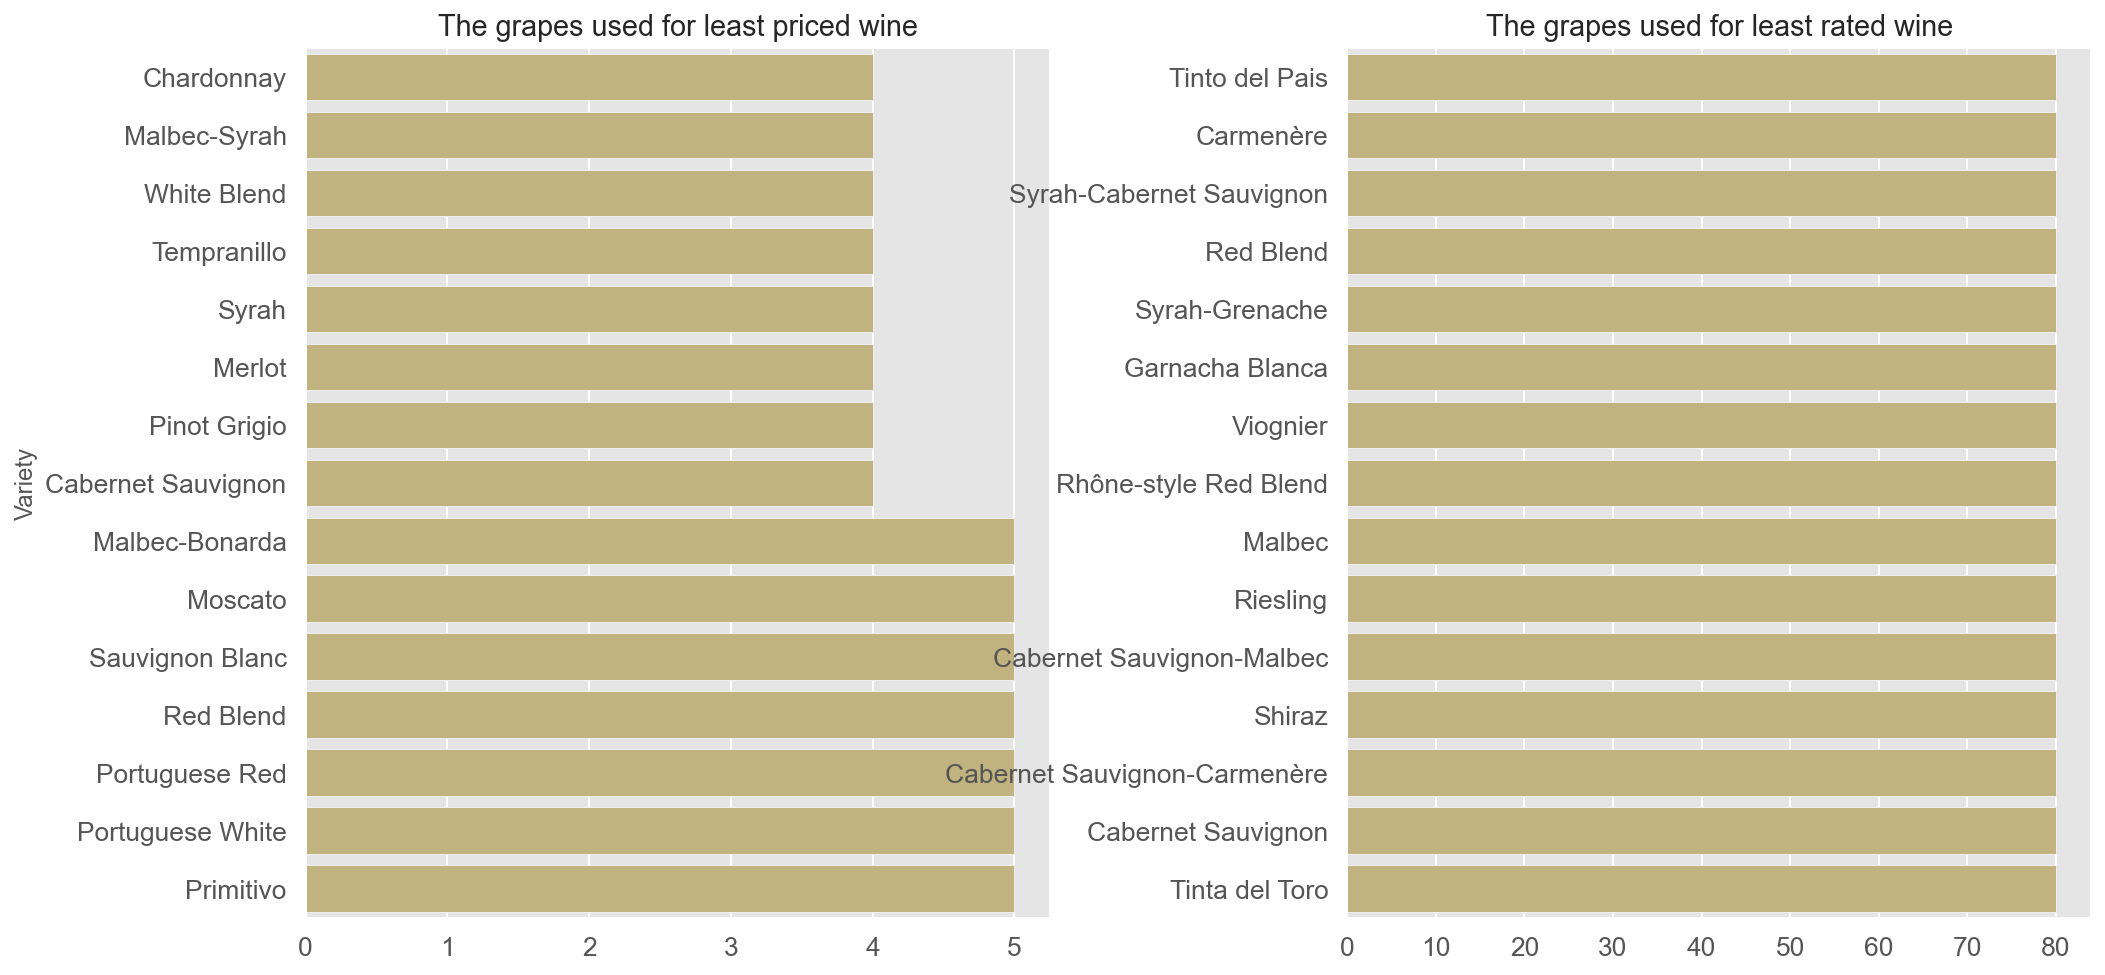

In [20]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['variety'])['price'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='y',ax=ax1)
ax1.set_title('The grapes used for least priced wine')
ax1.set_xlabel('')
ax1.set_ylabel('Variety')
w = df.groupby(['variety'])['points'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='y', ax=ax2)
ax2.set_title('The grapes used for least rated wine')
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.subplots_adjust(wspace=0.4);

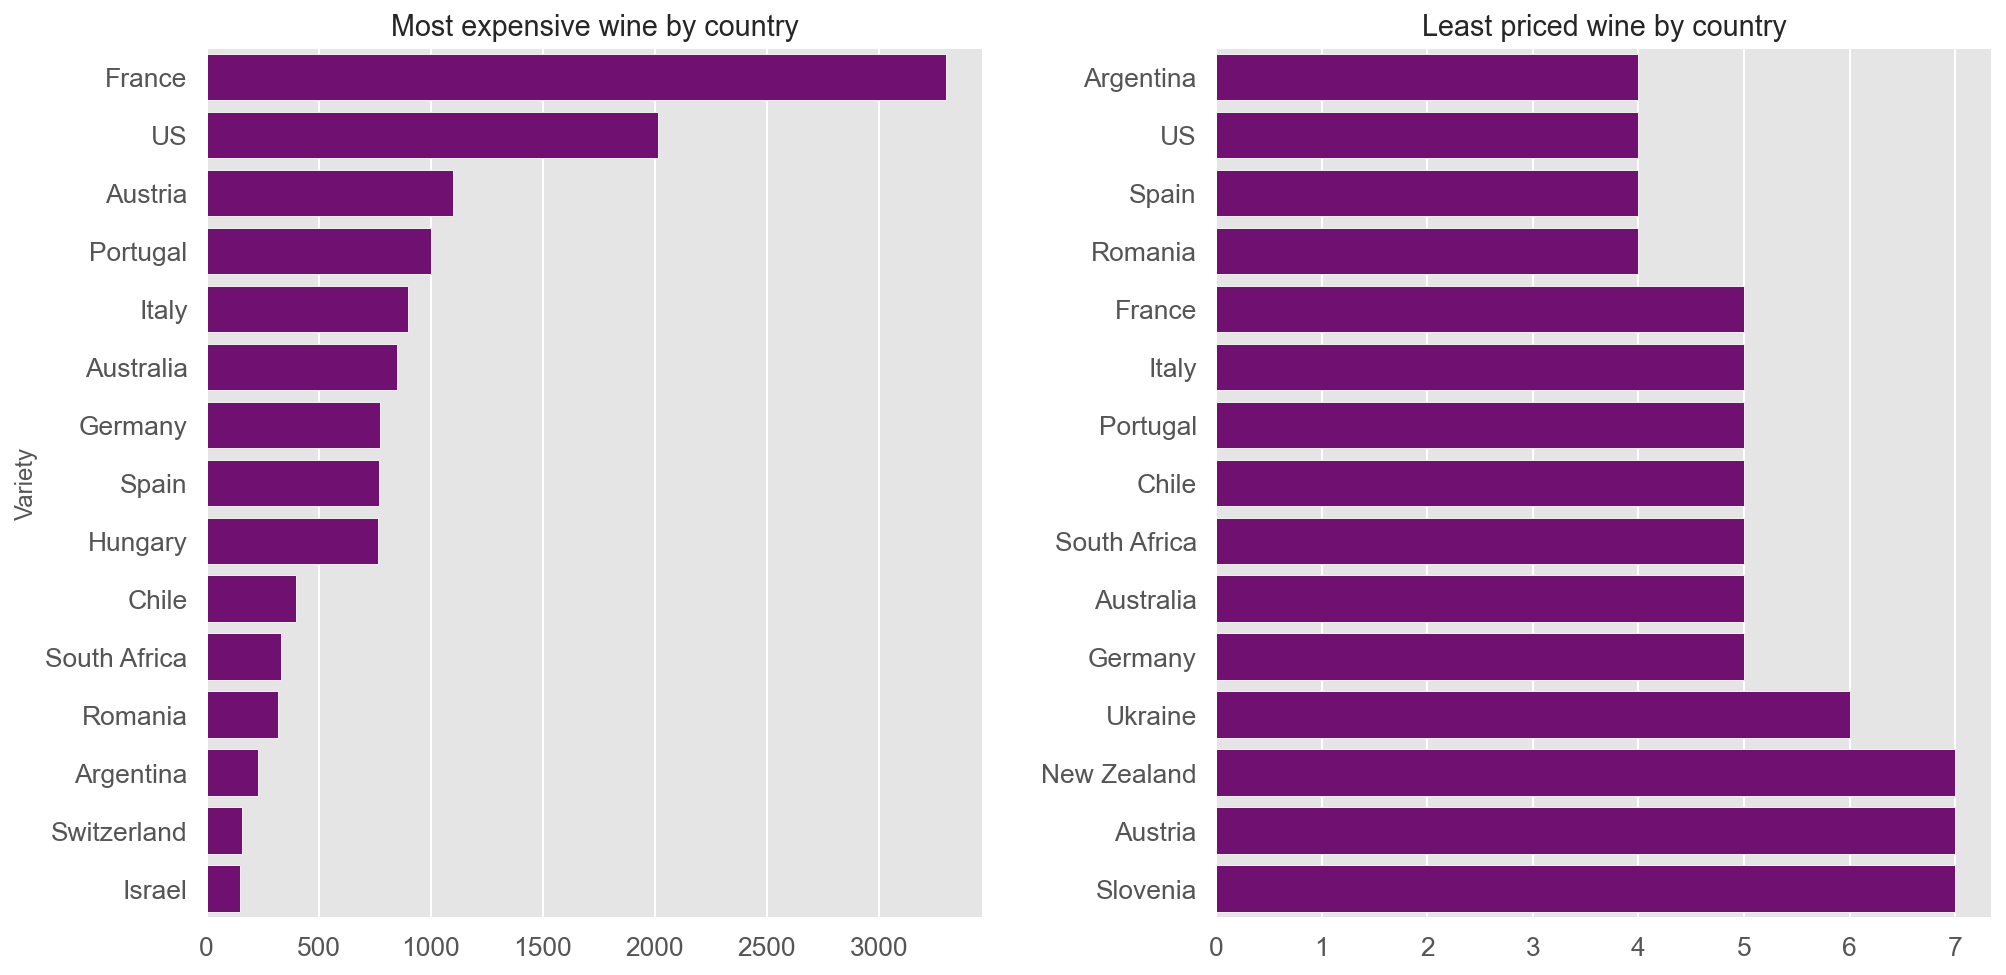

In [21]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['country'])['price'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='purple',ax=ax1)
ax1.set_title('Most expensive wine by country')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['country'])['price'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='purple',ax=ax2)
ax2.set_title('Least priced wine by country')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

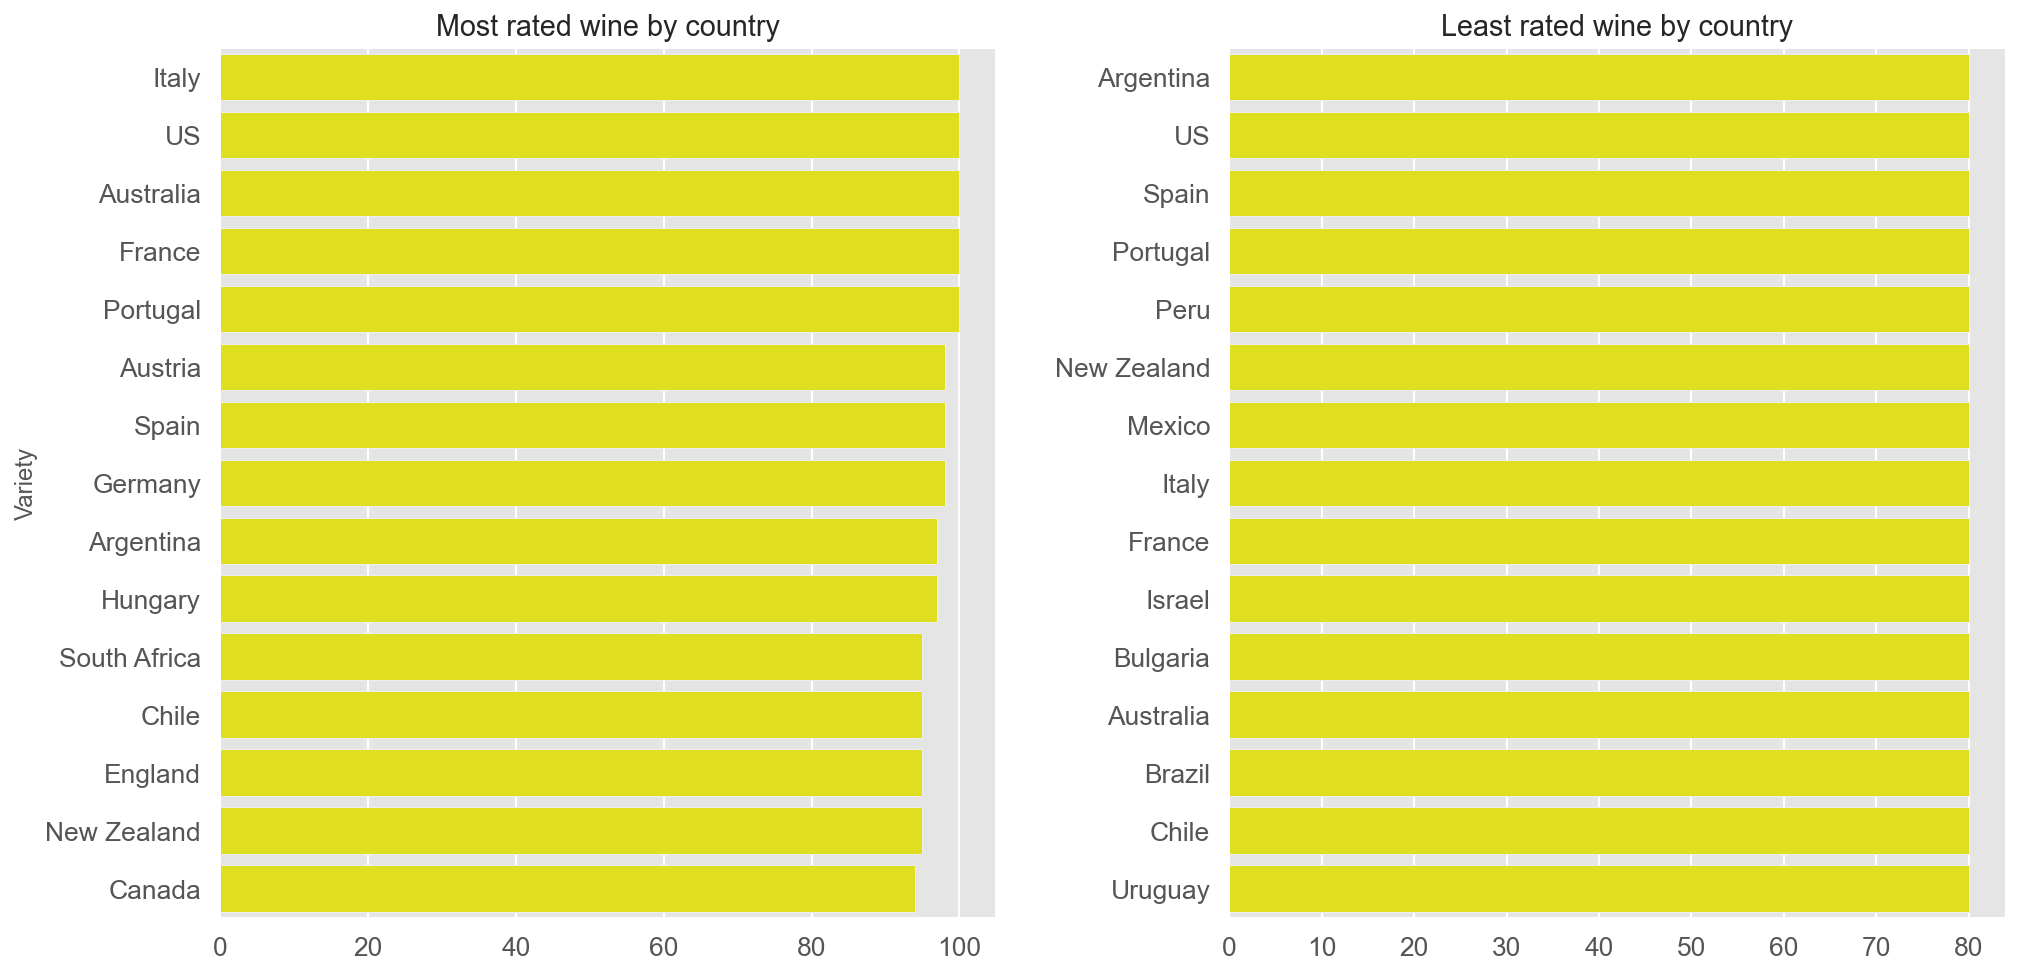

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['country'])['points'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='yellow',ax=ax1)
ax1.set_title('Most rated wine by country')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['country'])['points'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='yellow',ax=ax2)
ax2.set_title('Least rated wine by country')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

Number of province list in data: 425


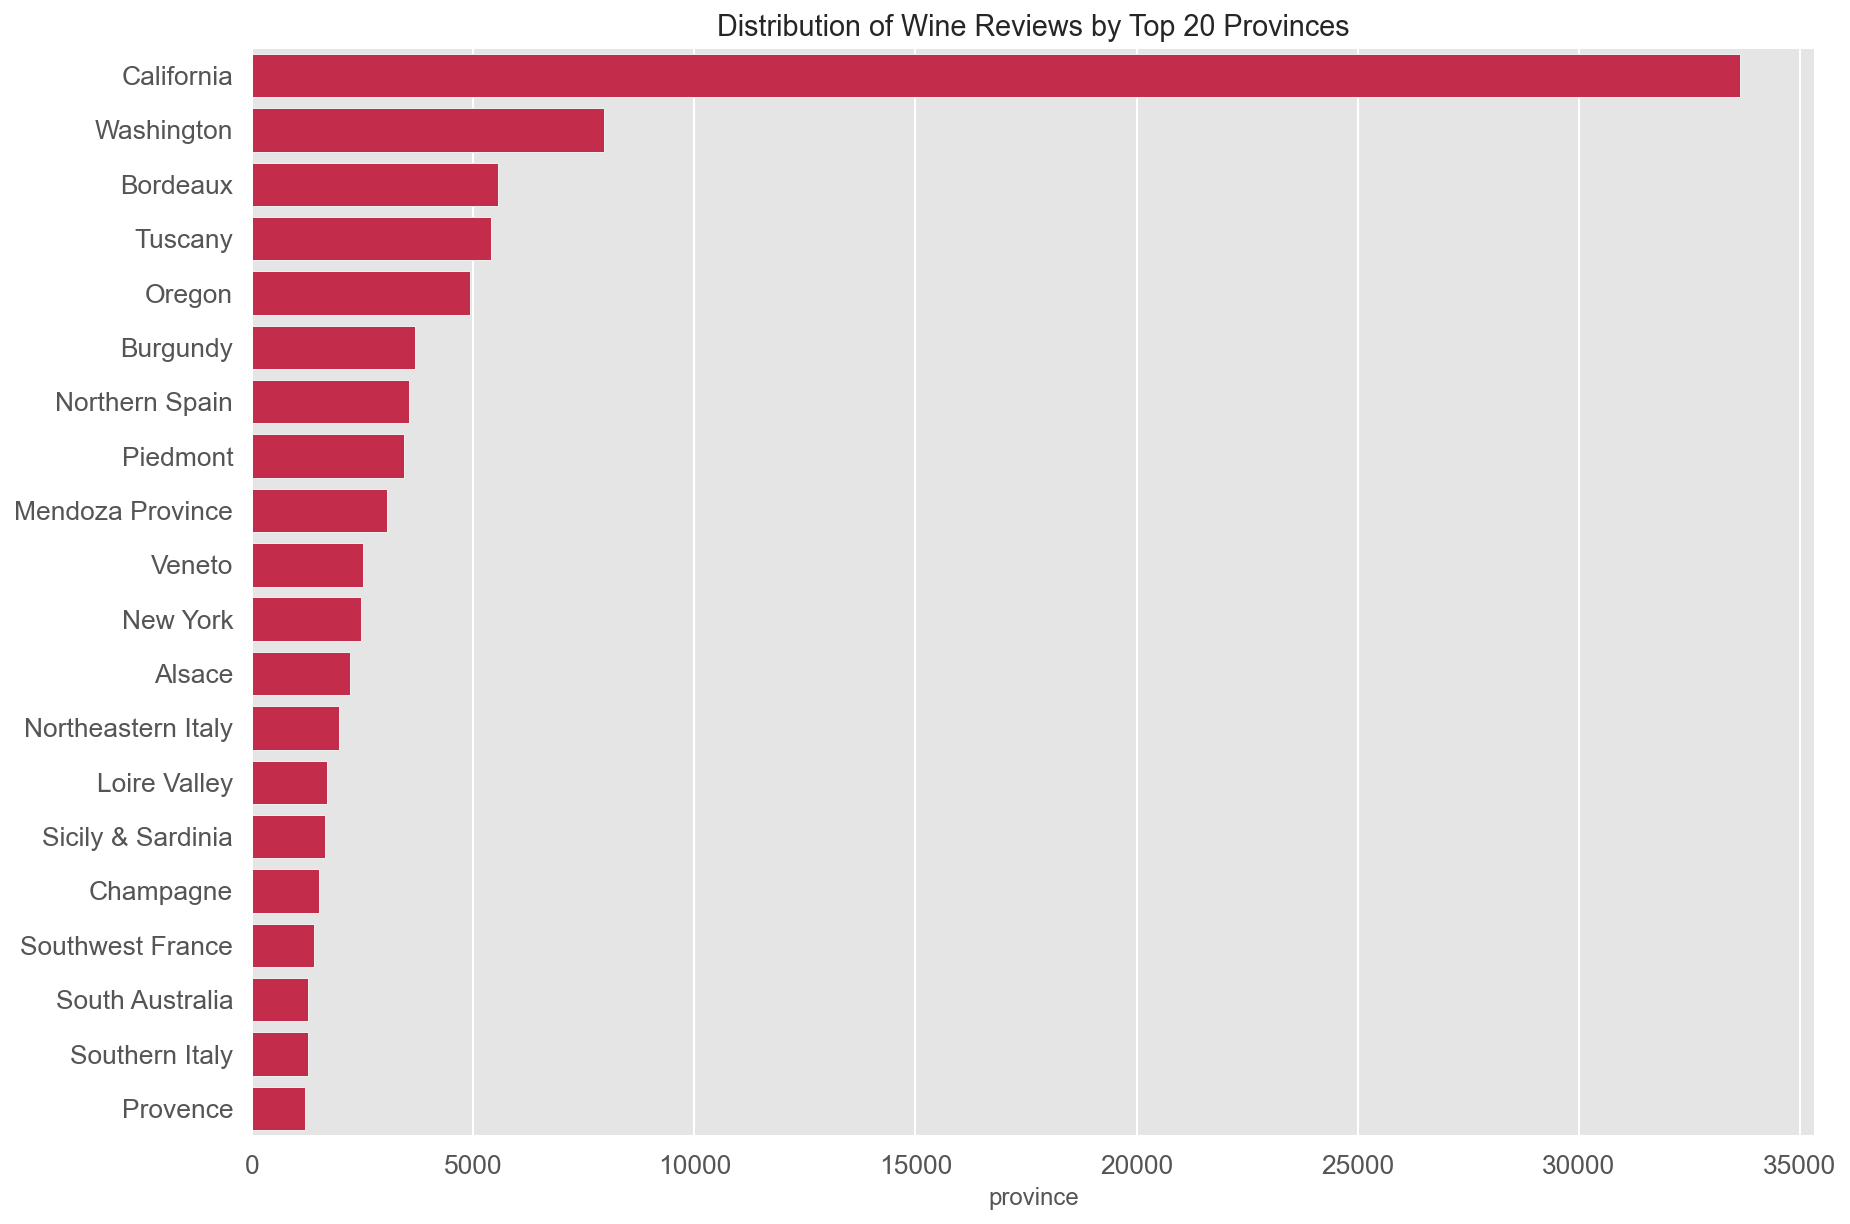

In [23]:
print(Fore.BLUE + Style.BRIGHT + 'Number of province list in data:', df['province'].nunique())
plt.figure(figsize=(14,10))
w = df['province'].value_counts().to_frame()[0:20]
#plt.xscale('log')
sns.barplot(x= w['province'], y =w.index, data=w, color='crimson', orient='h')
plt.title('Distribution of Wine Reviews by Top 20 Provinces');

Number of vineyard designation 37980


d:\pyenv\common\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

d:\pyenv\common\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



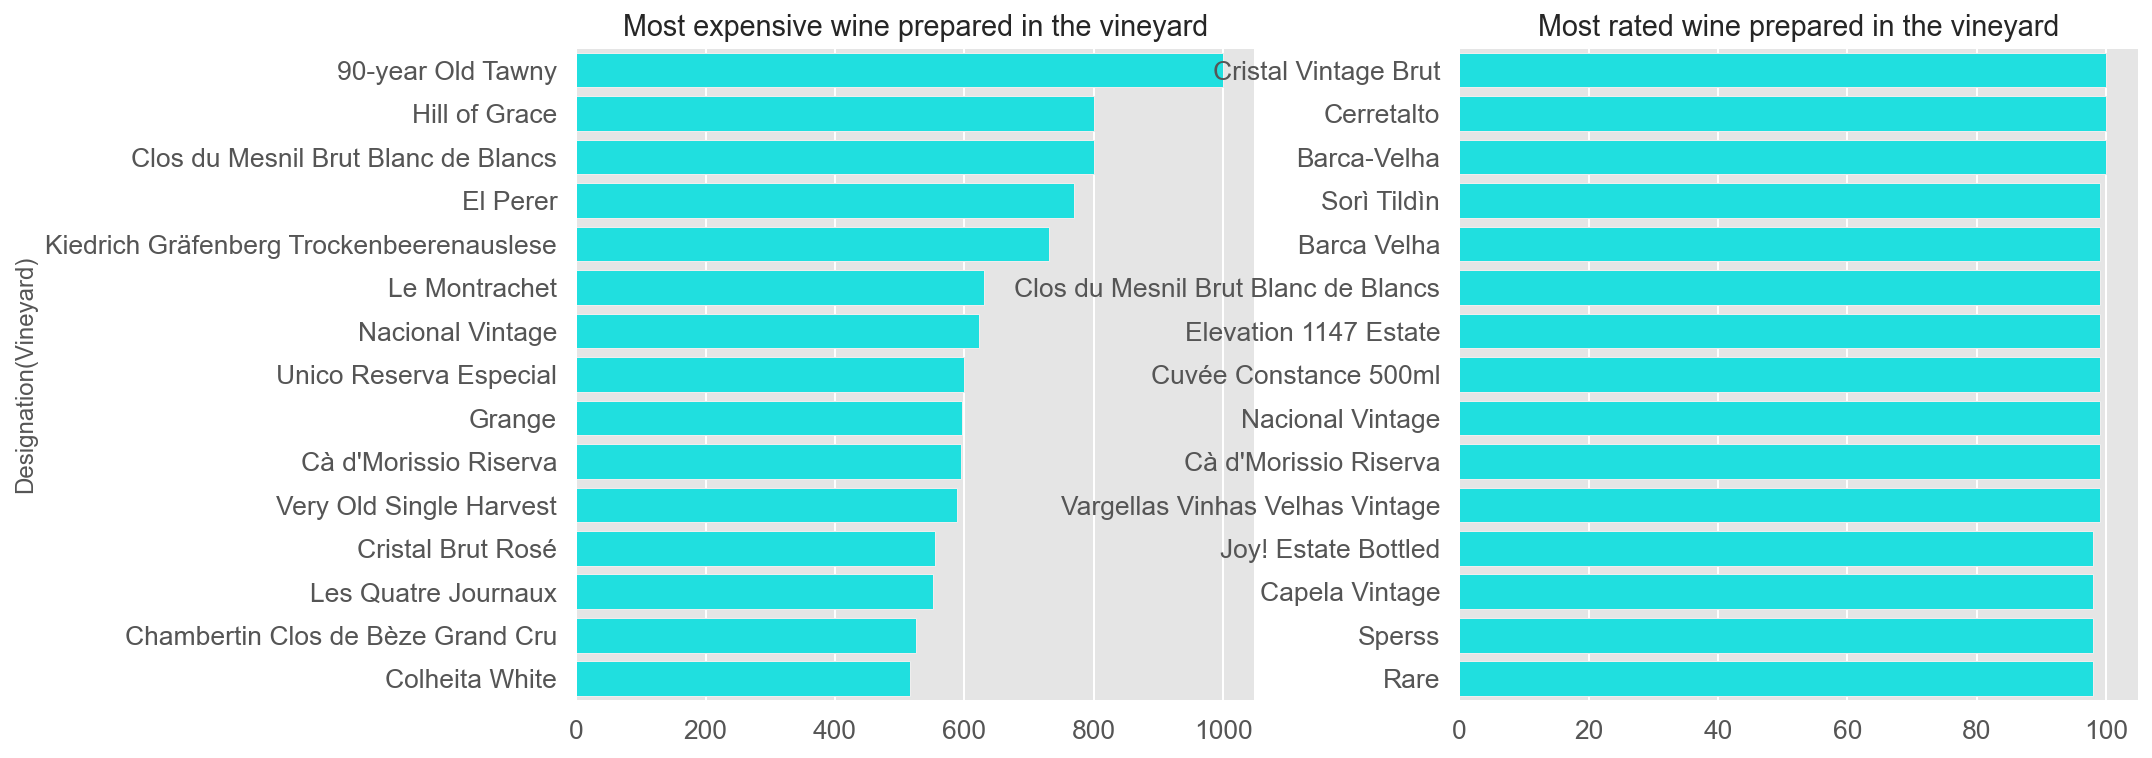

In [24]:
print(Fore.RED + Style.BRIGHT + 'Number of vineyard designation', df['designation'].nunique())
w = df.groupby(['designation'])['price'].mean().to_frame().sort_values(by='price',ascending=False)[:15]
f,ax = plt.subplots(1,2,figsize= (14,6))
ax1,ax2 = ax.flatten()
sns.barplot(w['price'], y = w.index, color='cyan', ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Designation(Vineyard)')
ax1.set_title('Most expensive wine prepared in the vineyard')
w = df.groupby(['designation'])['points'].mean().to_frame().sort_values(by = 'points', ascending = False)[:15]
sns.barplot(w['points'], y = w.index, color='cyan', ax = ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Most rated wine prepared in the vineyard')
plt.subplots_adjust(wspace=0.3)

Number of wineries: 16757


d:\pyenv\common\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

d:\pyenv\common\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



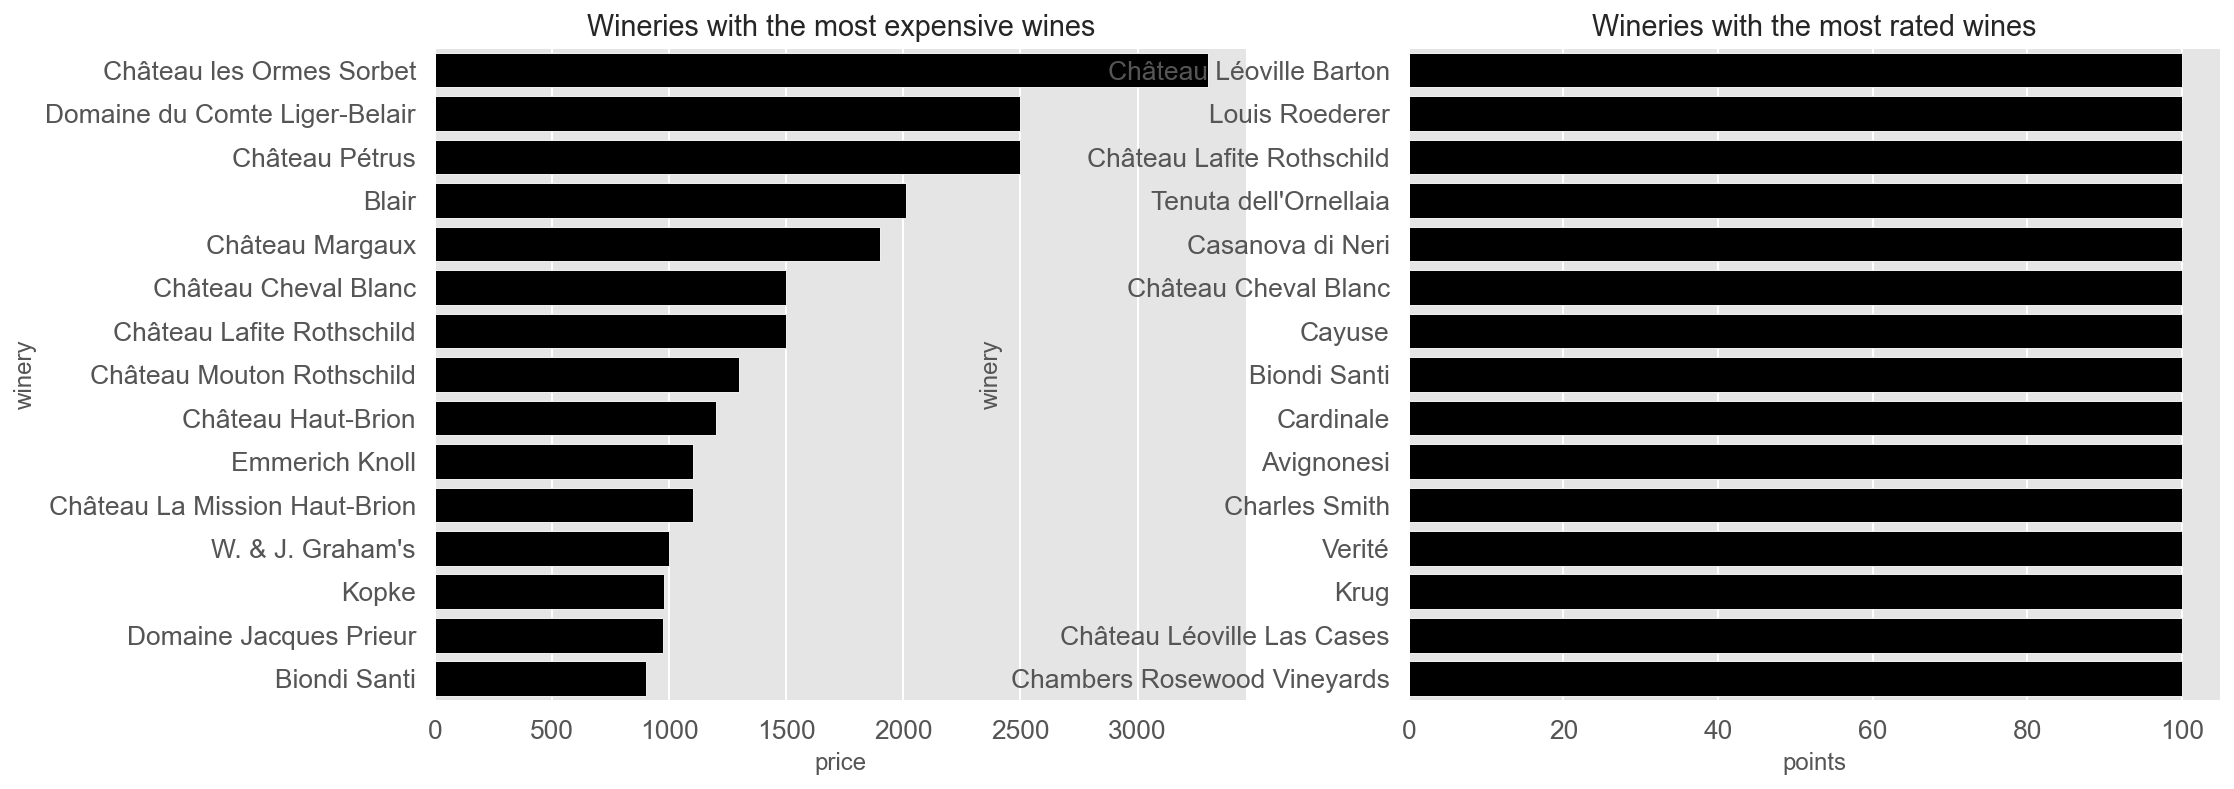

In [25]:
print(Fore.RED + Style.BRIGHT + 'Number of wineries:', df['winery'].nunique())
f,ax = plt.subplots(1,2,figsize=(16,6))
ax1,ax2 = ax.flatten()
w = df.groupby(['winery'])['price'].max().to_frame().sort_values(by='price',ascending=False)[:15]
sns.barplot(w['price'],y = w.index, color='black',ax = ax1)
ax1.set_title('Wineries with the most expensive wines')
w = df.groupby(['winery'])['points'].max().to_frame().sort_values(by = 'points', ascending = False)[:15]
sns.barplot(w['points'], y = w.index, color='black')
plt.title('Wineries with the most rated wines');

(-0.5, 999.5, 799.5, -0.5)

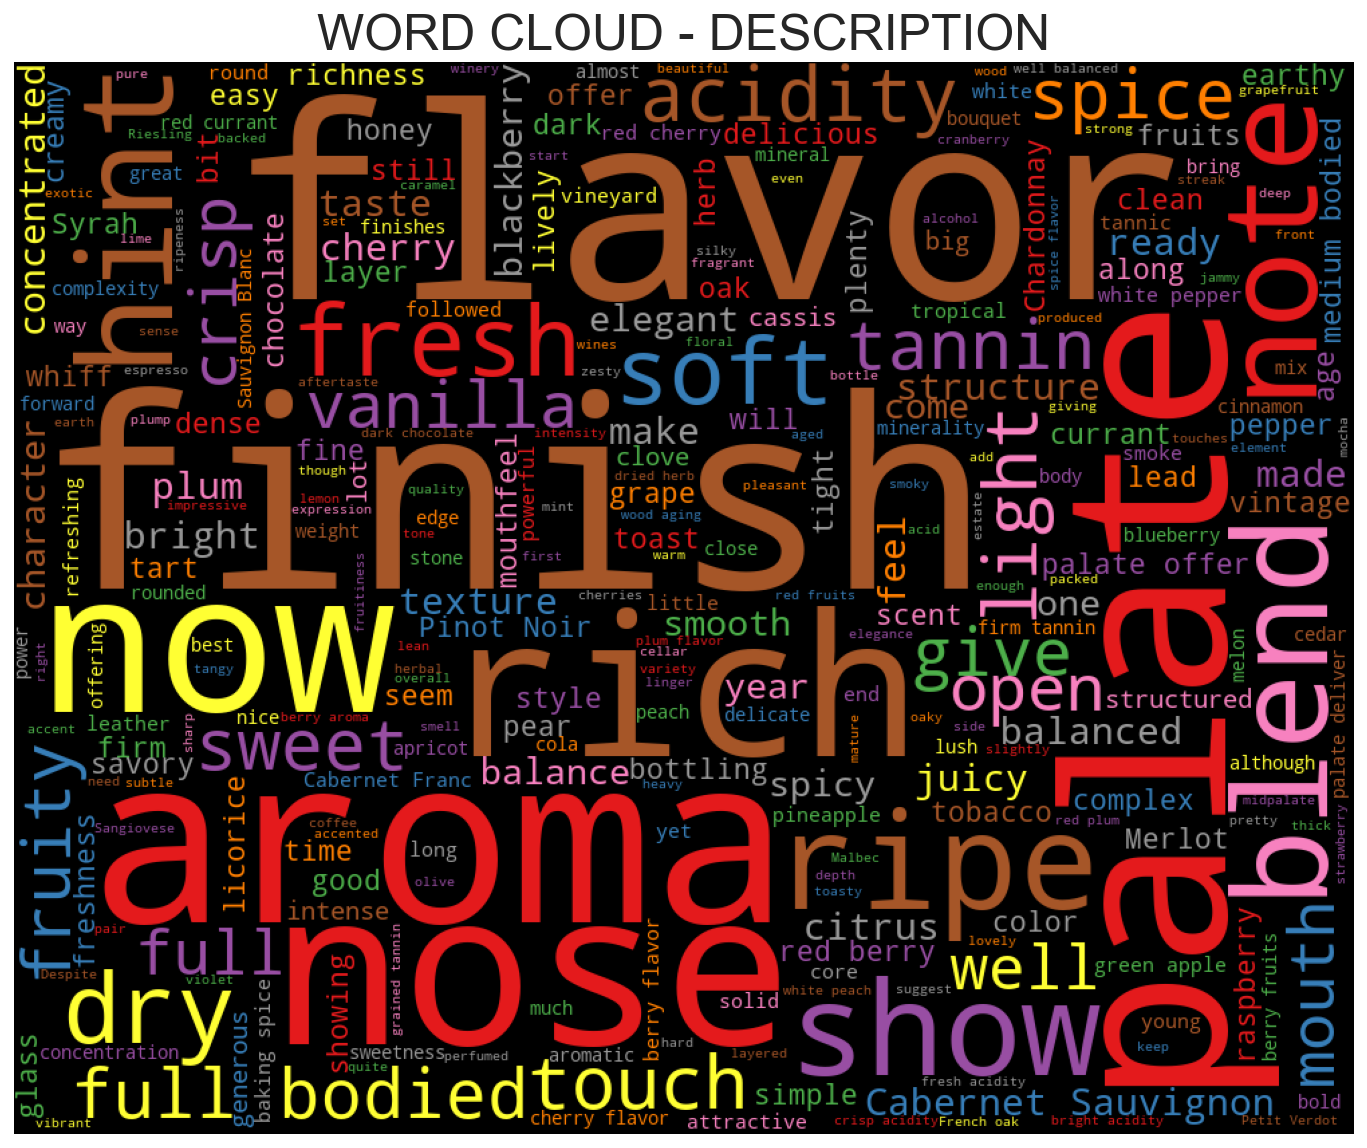

In [26]:
stopwords = set(STOPWORDS)
newStopWords = ['fruit', "Drink", "black", 'wine', 'drink']
stopwords.update(newStopWords)
wordcloud = WordCloud(
    stopwords=stopwords,
    colormap='Set1',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['description'].astype(str)))
print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - DESCRIPTION",fontsize=25)
plt.axis('off')

(-0.5, 999.5, 799.5, -0.5)

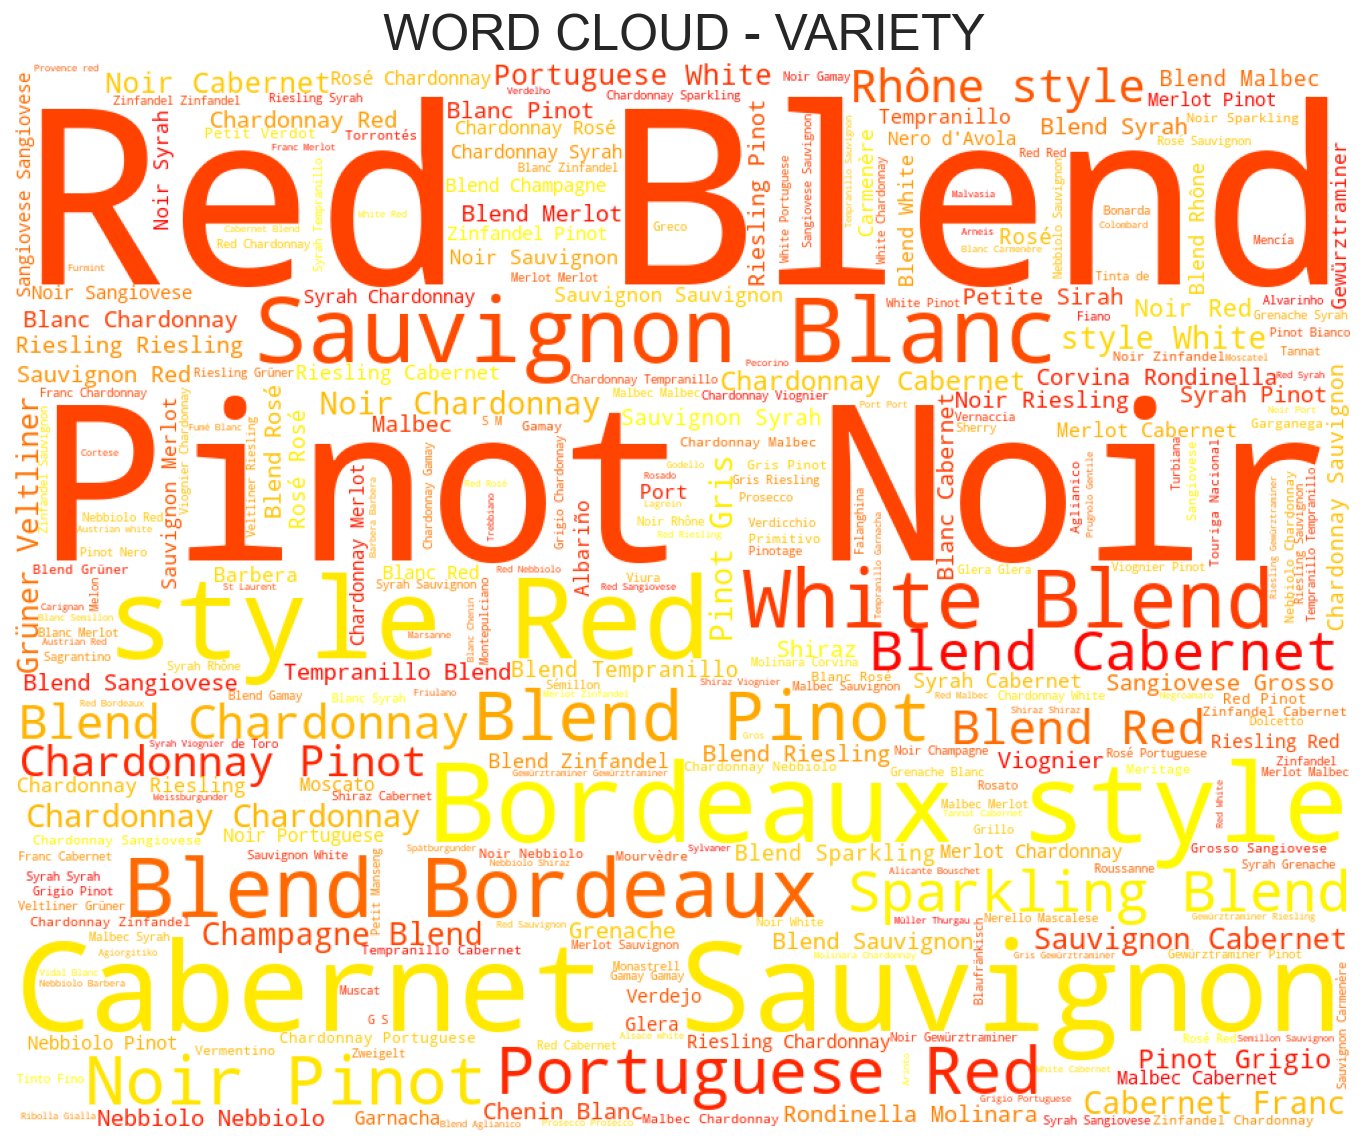

In [27]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    colormap='autumn_r',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['variety'].astype(str)))
print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - VARIETY",fontsize=25)
plt.axis('off')

In [28]:
import spacy
nlp = spacy.load('en_core_web_lg')
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>©', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")
print('ok')

ok


In [29]:
# Removing code syntax from text 
df['description_Cleaned_1'] = df['description'].apply(normalize_text)

In [30]:
print(Fore.MAGENTA + 'Before normalizing text-----\n')
print(df['description'])
print(Fore.YELLOW + Style.DIM + '\nAfter normalizing text-----\n')
print(df['description_Cleaned_1'])

Before normalizing text-----

0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 119988, dtype: object

After normalizing text-----

0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blo

In [31]:
from spacy import displacy
about_interest_text = ('I like different types of wine')
about_interest_doc = nlp(about_interest_text)
displacy.render(about_interest_doc, style='dep')

In [32]:
# Stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
len(spacy_stopwords)
for stop_word in list(spacy_stopwords)[:10]:
    print(Fore.CYAN + stop_word)

latter
less
not
behind
everything
meanwhile
fifteen
up
side
does


In [33]:
doc = nlp(df["description"][3])

In [34]:
review = str(" ".join([i.lemma_ for i in doc]))

In [35]:
doc = nlp(review)
spacy.displacy.render(doc, style='ent', jupyter=True)

d:\pyenv\common\deeplearning\lib\site-packages\spacy\displacy\__init__.py:189: UserWarning:

[W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.



In [36]:
# 词性标注
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
punctuations = string.punctuation
stopwords = STOP_WORDS

In [37]:
# 词性标注
for i in nlp(review):
    print(i, Fore.GREEN + "=>",i.pos_)

pineapple => NOUN
rind => NOUN
, => PUNCT
lemon => NOUN
pith => NOUN
and => CCONJ
orange => NOUN
blossom => NOUN
start => VERB
off => ADP
the => DET
aroma => NOUN
. => PUNCT
the => DET
palate => NOUN
be => AUX
a => DET
bit => NOUN
more => ADV
opulent => ADJ
, => PUNCT
with => ADP
note => NOUN
of => ADP
honey => NOUN
- => PUNCT
drizzle => NOUN
guava => NOUN
and => CCONJ
mango => NOUN
give => VERB
way => NOUN
to => ADP
a => DET
slightly => ADV
astringent => ADJ
, => PUNCT
semidry => PROPN
finish => NOUN
. => PUNCT


In [38]:
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [120]:
tqdm.pandas()
df["processed_description"] = df["description"].progress_apply(spacy_tokenizer)

d:\pyenv\common\deeplearning\lib\site-packages\tqdm\std.py:699: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

100%|█████████████████████████████████████████████████████████████████████████████| 59876/59876 [00:10<00:00, 5722.32it/s]


In [40]:
# Topic Modeling
# Creating a vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df["processed_description"])


In [135]:
df["processed_description"].iloc[0:10]

3     pineapple rind lemon pith orange blossom start...
4     like regular bottling 2012 comes rough tannic ...
10    soft supple plum envelopes oaky structure cabe...
12    slightly reduced wine offers chalky tannic bac...
14    building 150 years generations winemaking trad...
15    zesty orange peels apple notes abound sprightl...
20    ripe aromas dark berries mingle ample notes bl...
21    sleek mix tart berry stem herb hint oak chocol...
25    oak earth intermingle robust aromas wet forest...
28    aromas suggest mature berry scorched earth ani...
Name: processed_description, dtype: object

In [133]:
print( vectorizer.fit_transform(df["processed_description"].iloc[0:10]))

  (1, 1)	1
  (2, 1)	1
  (3, 1)	1
  (3, 0)	1
  (4, 1)	1
  (6, 0)	1
  (7, 1)	1
  (7, 0)	2
  (8, 0)	1
  (9, 0)	1


In [42]:
NUM_TOPICS = 10

In [43]:
# Latent Dirichlet Allocation Model
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [44]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized)

d:\pyenv\common\deeplearning\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [45]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [46]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [47]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print(Back.RED + "LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('apple', 12374.927817545173), ('palate', 11769.329844364182), ('finish', 10301.48204337458), ('citrus', 9256.200953697755), ('flavors', 9226.56445292276), ('lemon', 8709.355152343735), ('white', 8478.054450966278), ('peach', 7556.670452262894), ('aromas', 7440.828307172525), ('pear', 7081.9440492903195)]
Topic 1:
[('wine', 33173.02156535101), ('acidity', 16412.343531587187), ('drink', 15774.584436051078), ('ripe', 13222.536144823569), ('fruits', 11753.338840208738), ('fruit', 9412.970710771217), ('flavors', 7726.852185302843), ('red', 7635.629648368989), ('character', 7617.332543453811), ('fruity', 6765.643249658264)]
Topic 2:
[('nose', 4771.532058322748), ('bottling', 3354.189570275877), ('palate', 2180.7709130299704), ('dried', 1436.3133675244999), ('based', 1392.801418006022), ('tightly', 1377.1047546360553), ('heavy', 1230.8036294584542), ('shows', 1180.4275803682217), ('extra', 1126.999422624822), ('dominate', 1067.3623521600748)]
Topic 3:
[('cherry', 14108.6

In [48]:
# Keywords for topics clustered by Latent Semantic Indexing
print(Back.BLUE + "NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('flavors', 18.639790333299803), ('aromas', 2.565031804128332), ('sweet', 2.009328687956618), ('dry', 1.8509099502697008), ('oak', 1.4856484230282767), ('good', 1.3468796778715162), ('vanilla', 1.1786165957218684), ('blackberry', 1.1242004597265993), ('like', 1.0034871048770855), ('rich', 0.7693843271599689)]
Topic 1:
[('wine', 14.966281371397464), ('fruits', 0.8706833573872412), ('texture', 0.8453425656873218), ('rich', 0.7905508180347361), ('character', 0.7775233885502012), ('wood', 0.6221512820118673), ('aging', 0.5799757007117136), ('age', 0.560682950430793), ('structure', 0.539205875012649), ('bodied', 0.48070888139425044)]
Topic 2:
[('black', 11.10774022811508), ('tannins', 3.802515324023443), ('cherry', 2.120965342708021), ('pepper', 2.017435286626039), ('dark', 1.9091207159932684), ('plum', 1.6110919318613948), ('blackberry', 1.300850821547166), ('licorice', 1.0612177639808578), ('currant', 1.056283509416683), ('firm', 1.038580258873696)]
Topic 3:
[('palate

In [49]:
# Keywords for topics clustered by Non-Negative Matrix Factorization
print(Back.MAGENTA + "LSI Model:")
selected_topics(lsi, vectorizer)

LSI Model:
Topic 0:
[('wine', 0.46768574412160285), ('flavors', 0.33722295803186936), ('fruit', 0.276357208865789), ('aromas', 0.21235566104186182), ('palate', 0.1986954473696995), ('acidity', 0.185642248642091), ('tannins', 0.179212074622701), ('finish', 0.17819852636234634), ('black', 0.17480465031177556), ('drink', 0.17128283578764297)]
Topic 1:
[('wine', 0.6748810261345022), ('drink', 0.11588475110588649), ('acidity', 0.11238478213387797), ('fruits', 0.10601829487880192), ('rich', 0.08609057273611519), ('ripe', 0.07539352850701903), ('character', 0.061698701825430594), ('texture', 0.06075973695740941), ('fruity', 0.05629591245631662), ('aging', 0.05217720625228231)]
Topic 2:
[('black', 0.4423092674312862), ('tannins', 0.3617322528055192), ('cherry', 0.27107743581027777), ('dark', 0.11077554169824423), ('red', 0.09919374427029581), ('firm', 0.09552309177030478), ('cabernet', 0.0940755667441908), ('pepper', 0.08470331468574153), ('drink', 0.08305625811513691), ('spice', 0.08041051366

In [50]:
# 编码一个句子
text = spacy_tokenizer("Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.")
x = lda.transform(vectorizer.transform([text]))[0]
print(x)

[0.68829739 0.00500035 0.00500071 0.27169931 0.00500078 0.00500048
 0.00500005 0.00500017 0.00500062 0.00500015]


In [51]:
# description and variety of grapes
df = df[['description', 'variety']]
df.head()

description         variety
0  Aromas include tropical fruit, broom, brimston...     White Blend
1  This is ripe and fruity, a wine that is smooth...  Portuguese Red
2  Tart and snappy, the flavors of lime flesh and...      Pinot Gris
3  Pineapple rind, lemon pith and orange blossom ...        Riesling
4  Much like the regular bottling from 2012, this...      Pinot Noir

In [52]:
# Getting top 8 most described variety
temp_df = df.variety.value_counts()
temp_df.head(8)

Pinot Noir                  12278
Chardonnay                  10868
Cabernet Sauvignon           8840
Red Blend                    8243
Bordeaux-style Red Blend     6471
Riesling                     4773
Sauvignon Blanc              4575
Syrah                        3828
Name: variety, dtype: int64

In [53]:
# For this project we are taking top 8 variety only
mask = df['variety'].isin(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend',
                           'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc',
                           'Syrah'])
df = df[mask]
df.head()

description             variety
3   Pineapple rind, lemon pith and orange blossom ...            Riesling
4   Much like the regular bottling from 2012, this...          Pinot Noir
10  Soft, supple plum envelopes an oaky structure ...  Cabernet Sauvignon
12  Slightly reduced, this wine offers a chalky, t...  Cabernet Sauvignon
14  Building on 150 years and six generations of w...          Chardonnay

d:\pyenv\common\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



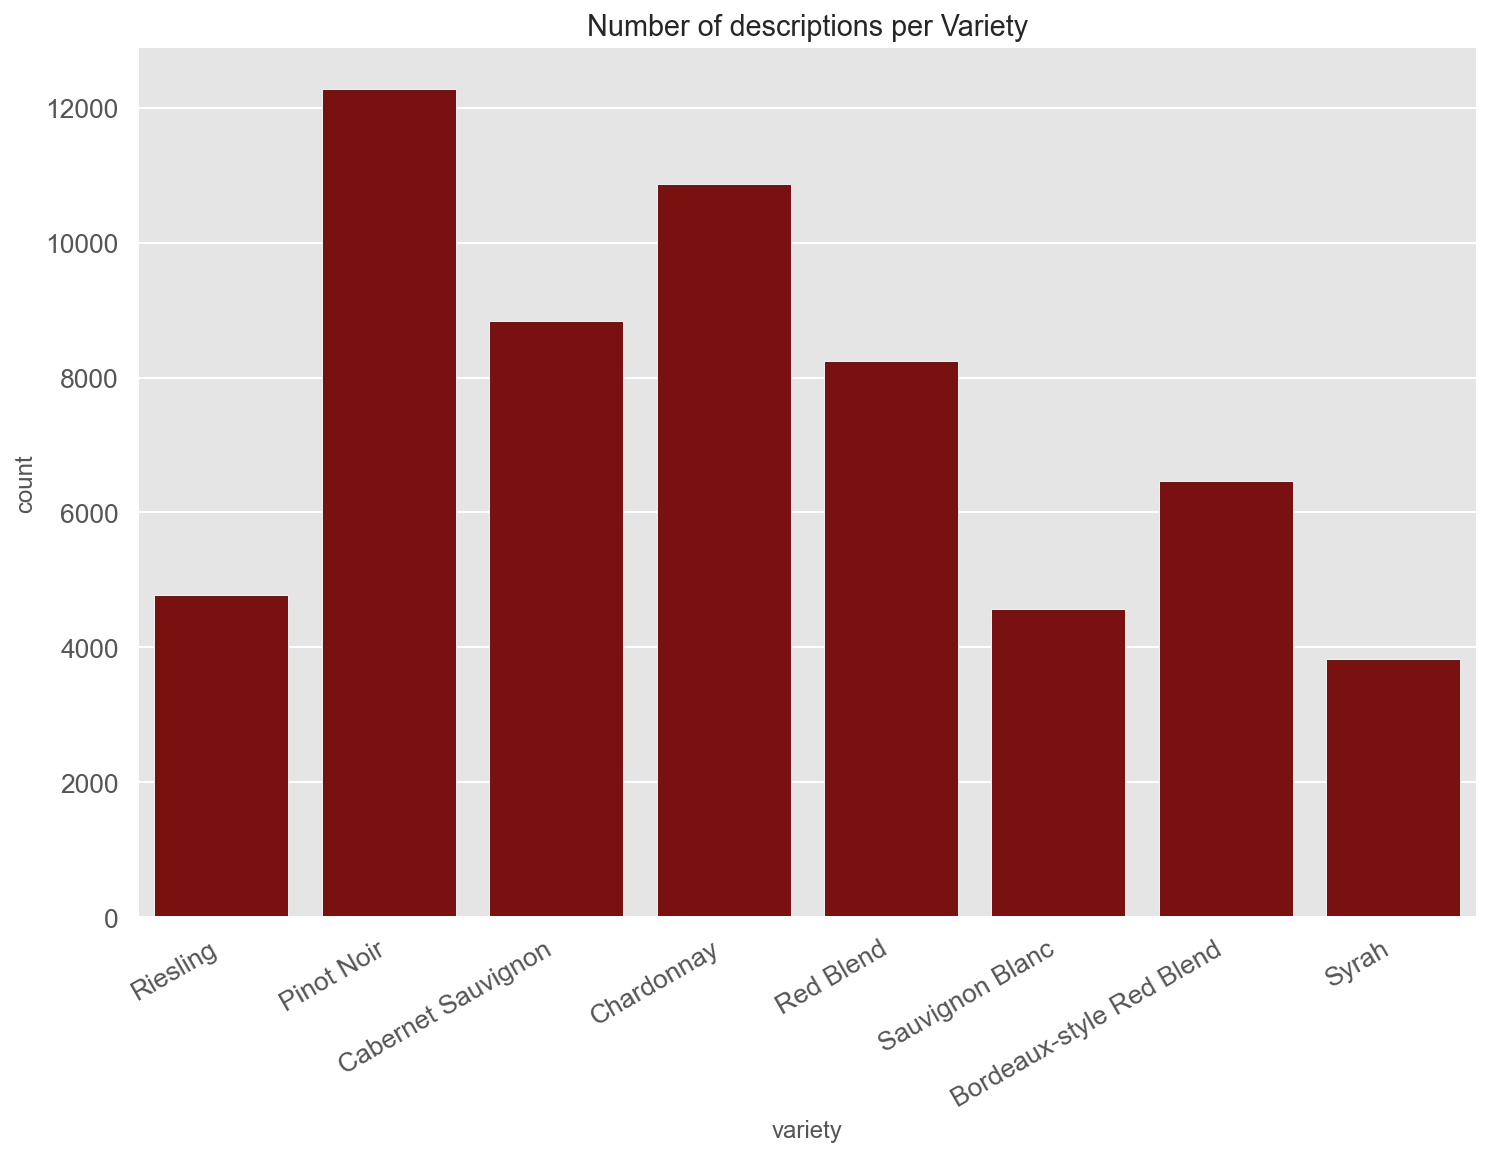

In [54]:
chart = sns.countplot(df.variety, color='darkred')
plt.title("Number of descriptions per Variety")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.description, df.variety, test_size = 0.2, random_state = 42)

In [56]:
train = { 'text': X_train, 'intent': y_train }
train_df = pd.DataFrame(train)
test = { 'text': X_test, 'intent': y_test }
test_df = pd.DataFrame(test)

In [57]:
train_df.head()

text  \
123119  The wine is seriously structured for the vinta...   
62381   Most 2006 Chilean Chardonnays are past their p...   
87314   Very dry and tannic, an austere young Cabernet...   
57262   Too soft for comfort, and too sweet, although ...   
93390   This is a structured wine that shows class and...   

                          intent  
123119  Bordeaux-style Red Blend  
62381                 Chardonnay  
87314         Cabernet Sauvignon  
57262         Cabernet Sauvignon  
93390   Bordeaux-style Red Blend

In [58]:
# Making the training dataset uniform - taking the wine with least number of count (i.e. Syrah)
syrah_df = train_df[train_df['intent']=='Syrah']
# Selecting other varities of wines
riesling_df = train_df[train_df['intent']=='Riesling']
pinot_noir_df = train_df[train_df['intent']=='Pinot Noir']
chardonnay_df = train_df[train_df['intent']=='Chardonnay']
cabernet_sauvignon_df = train_df[train_df['intent']=='Cabernet Sauvignon']
red_blend_df = train_df[train_df['intent']=='Red Blend']
bordeaux_style_red_blend_df = train_df[train_df['intent']=='Bordeaux-style Red Blend']
sauvignon_blanc_df = train_df[train_df['intent']=='Sauvignon Blanc']

In [59]:
# Setting their count equal to that of Syrah
pinot_noir_df = pinot_noir_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
chardonnay_df = chardonnay_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
cabernet_sauvignon_df = cabernet_sauvignon_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
red_blend_df = red_blend_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
bordeaux_style_red_blend_df = bordeaux_style_red_blend_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
riesling_df = riesling_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)
sauvignon_blanc_df = sauvignon_blanc_df.sample(n=len(syrah_df), random_state=RANDOM_SEED)

In [60]:
# Adding all the data together
syrah_df = syrah_df.append(pinot_noir_df).reset_index(drop=True)
syrah_df = syrah_df.append(chardonnay_df).reset_index(drop=True)
syrah_df = syrah_df.append(cabernet_sauvignon_df).reset_index(drop=True)
syrah_df = syrah_df.append(red_blend_df).reset_index(drop=True)
syrah_df = syrah_df.append(bordeaux_style_red_blend_df).reset_index(drop=True)
syrah_df = syrah_df.append(riesling_df).reset_index(drop=True)
syrah_df = syrah_df.append(sauvignon_blanc_df).reset_index(drop=True)
train_df = syrah_df
train_df.shape

(24368, 2)

d:\pyenv\common\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



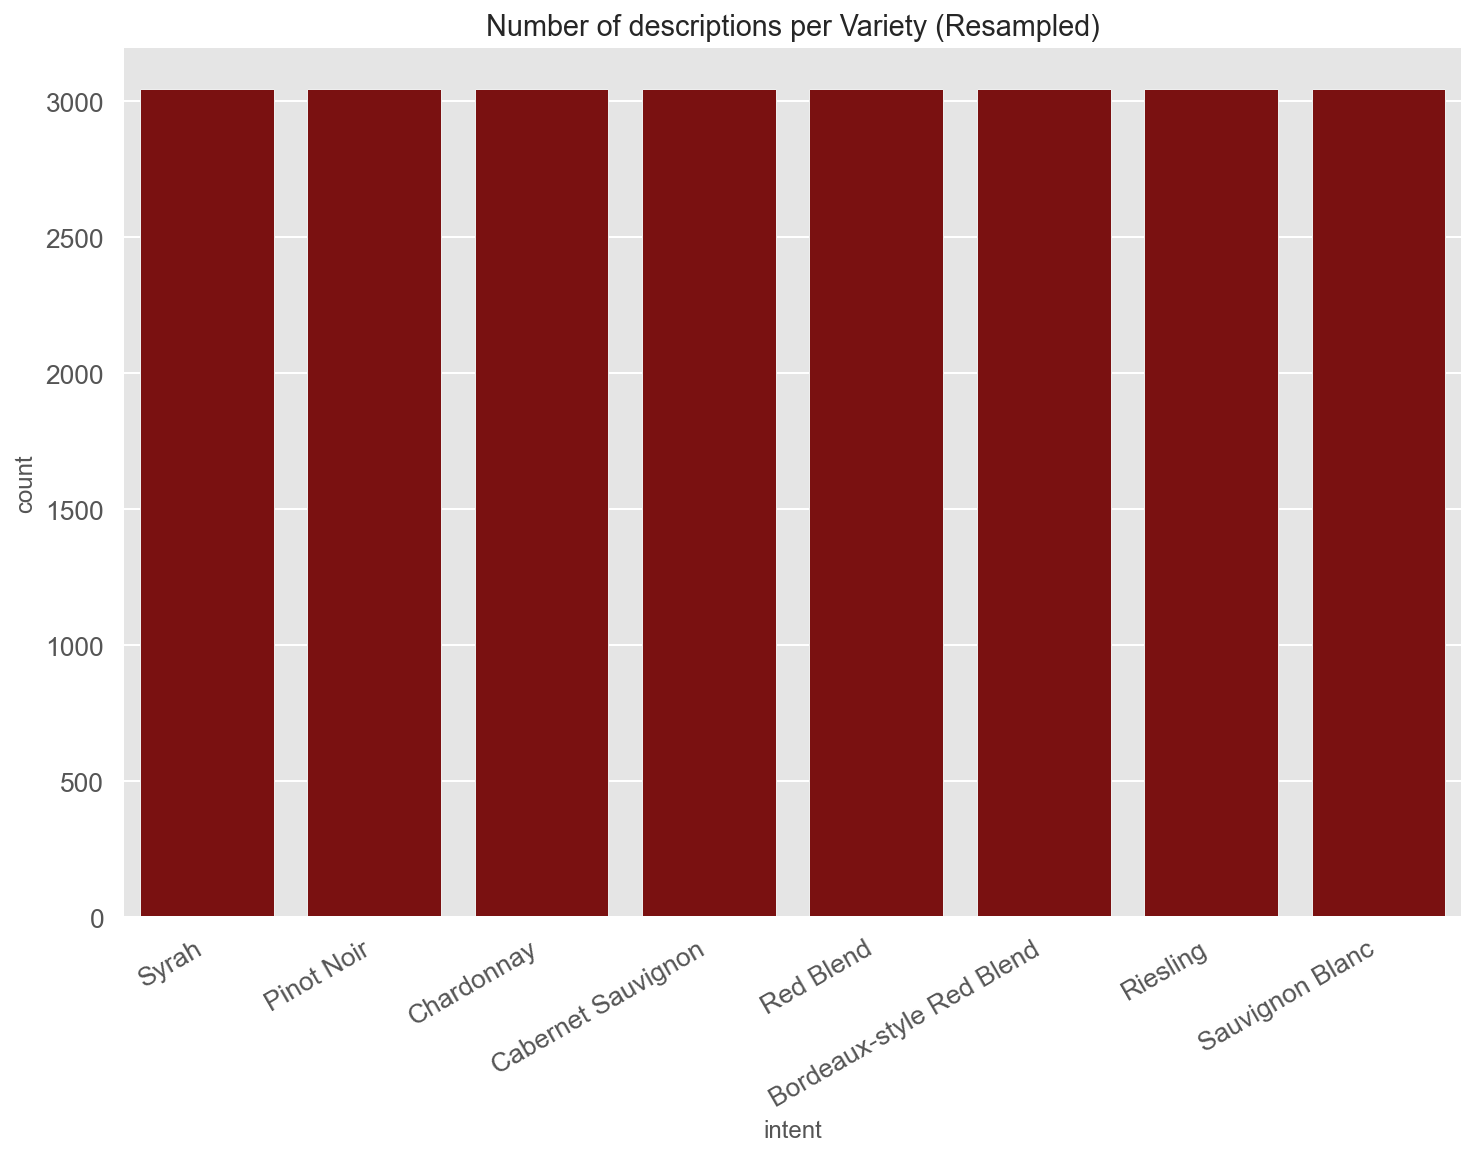

In [61]:
chart = sns.countplot(train_df.intent, color='darkred')
plt.title("Number of descriptions per Variety (Resampled)")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [62]:
# Shuffle
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [63]:
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [64]:
(2173*3.52+2439)*1.316 , 2173*.15*1.316

(13275.75536, 428.9502)

In [65]:
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [67]:
class IntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes
        train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
    def _prepare(self, df):
        x, y = [], []
        for _, row in tqdm(df.iterrows()):
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))
        return np.array(x), np.array(y)
    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [68]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [71]:
tokenizer.tokenize("I like red wine more than white wine")

['i', 'like', 'red', 'wine', 'more', 'than', 'white', 'wine']

In [72]:
tokens = tokenizer.tokenize("Wines from some countries are very underrated!")
tokenizer.convert_tokens_to_ids(tokens)

[14746, 2013, 2070, 3032, 2024, 2200, 2104, 9250, 999]

In [73]:
def create_model(max_seq_len, bert_ckpt_file):
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
    print("bert shape", bert_output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="swish")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)
    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    load_stock_weights(bert, bert_ckpt_file)
    return model

In [74]:
test_df.head()

text           intent
102043  An intriguing wine, with aromas of white peppe...            Syrah
59645   The wine is all about fresh apples and pears, ...       Chardonnay
83445   The allure of ripe but zingy passion fruit pro...  Sauvignon Blanc
73289   Oaky-sweet and simple, with jammy pineapple, t...       Chardonnay
69327   Spicy and dusty smelling, with full-force plum...       Pinot Noir

In [75]:
classes = train_df.intent.unique().tolist()
data = IntentDetectionData(train_df, test_df, tokenizer, classes, max_seq_len=128)

24368it [00:13, 1744.37it/s]
11976it [00:06, 1731.66it/s]


max seq_len 180


In [76]:
data.train_x[0]

array([  101, 10964,  2011,  1046,  2140, 15453, 10179,  7869,  1012,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [77]:
data.train_y[0]

5

In [78]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x000002658228AC40> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [79]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                

In [80]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [90]:
# print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2020-12-09 17:14:09


In [91]:
log_dir = "log/intent_detection/" + str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=10,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
   1/1371 [..............................] - ETA: 1s - loss: 2.0514 - acc: 0.1875WARNING:tensorflow:From d:\pyenv\common\deeplearning\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1371/1371 [==============================] - 916s 668ms/step - loss: 1.7087 - acc: 0.5664 - val_loss: 1.5036 - val_acc: 0.7702
Epoch 2/10
1371/1371 [==============================] - 910s 664ms/step - loss: 1.5234 - acc: 0.7514 - val_loss: 1.4862 - val_acc: 0.7891
Epoch 3/10
1371/1371 [==============================] - 909s 663ms/step - loss: 1.4840 - acc: 0.7908 - val_loss: 1.4644 - val_acc: 0.8088
Epoch 4/10
1371/1371 [==============================] - 910s 664ms/step - loss: 1.4641 - acc: 0.8107 - val_loss: 1.4697 - val_acc: 0.8039
Epoch 5/10
1371/1371 [==============================] - 911s 665ms/step - loss: 1

Text(0.5, 1.0, 'Loss over training epochs')

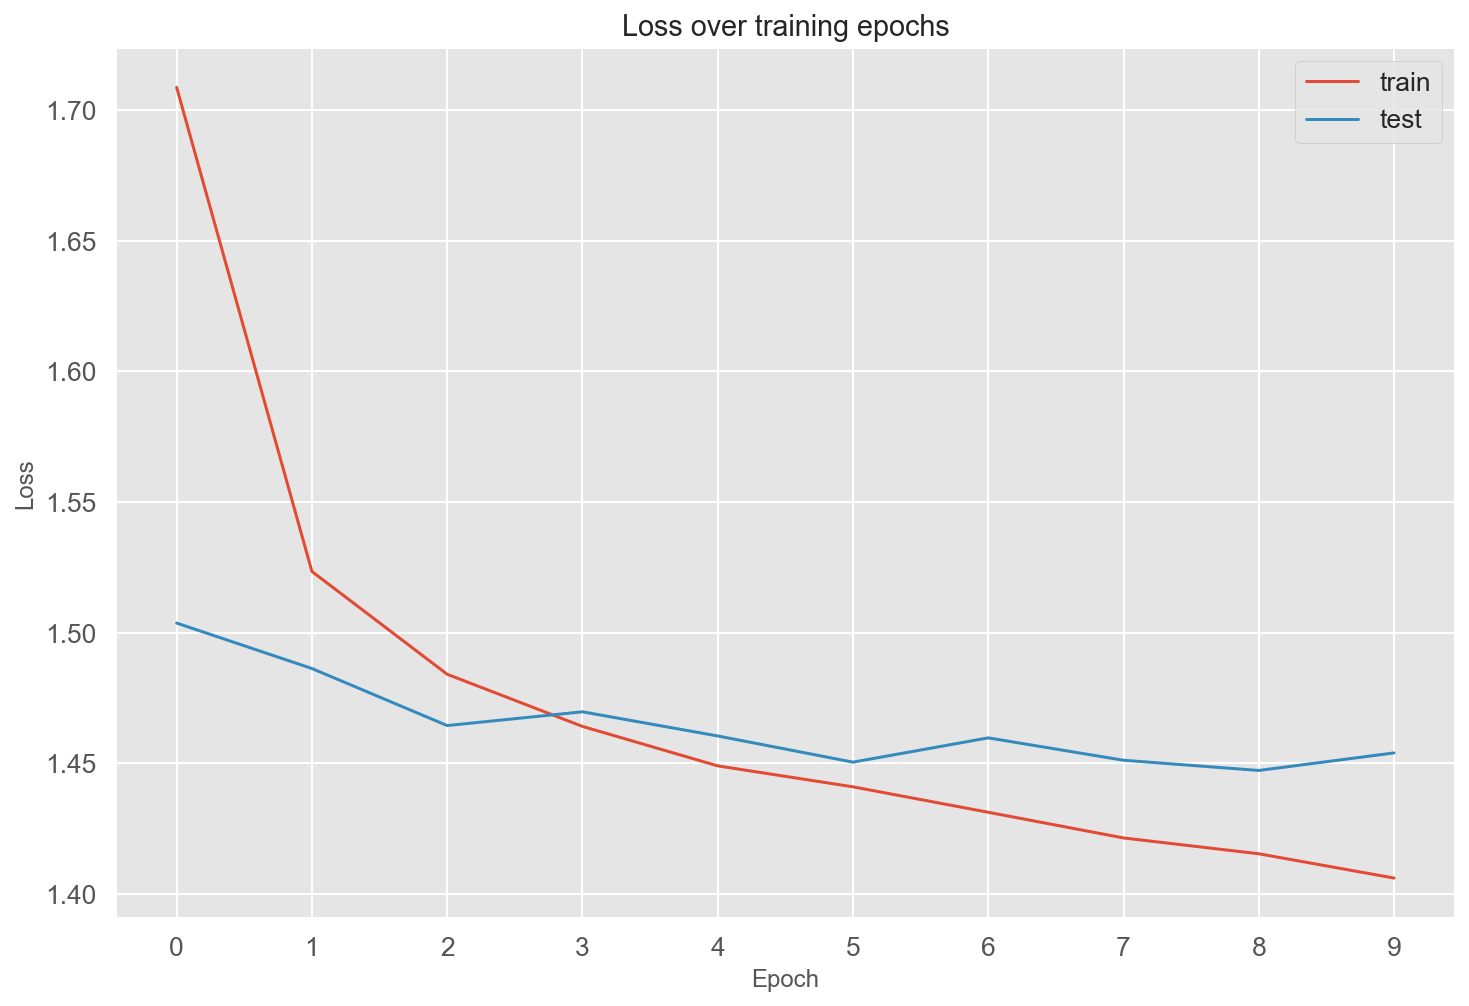

In [92]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')

Text(0.5, 1.0, 'Accuracy over training epochs')

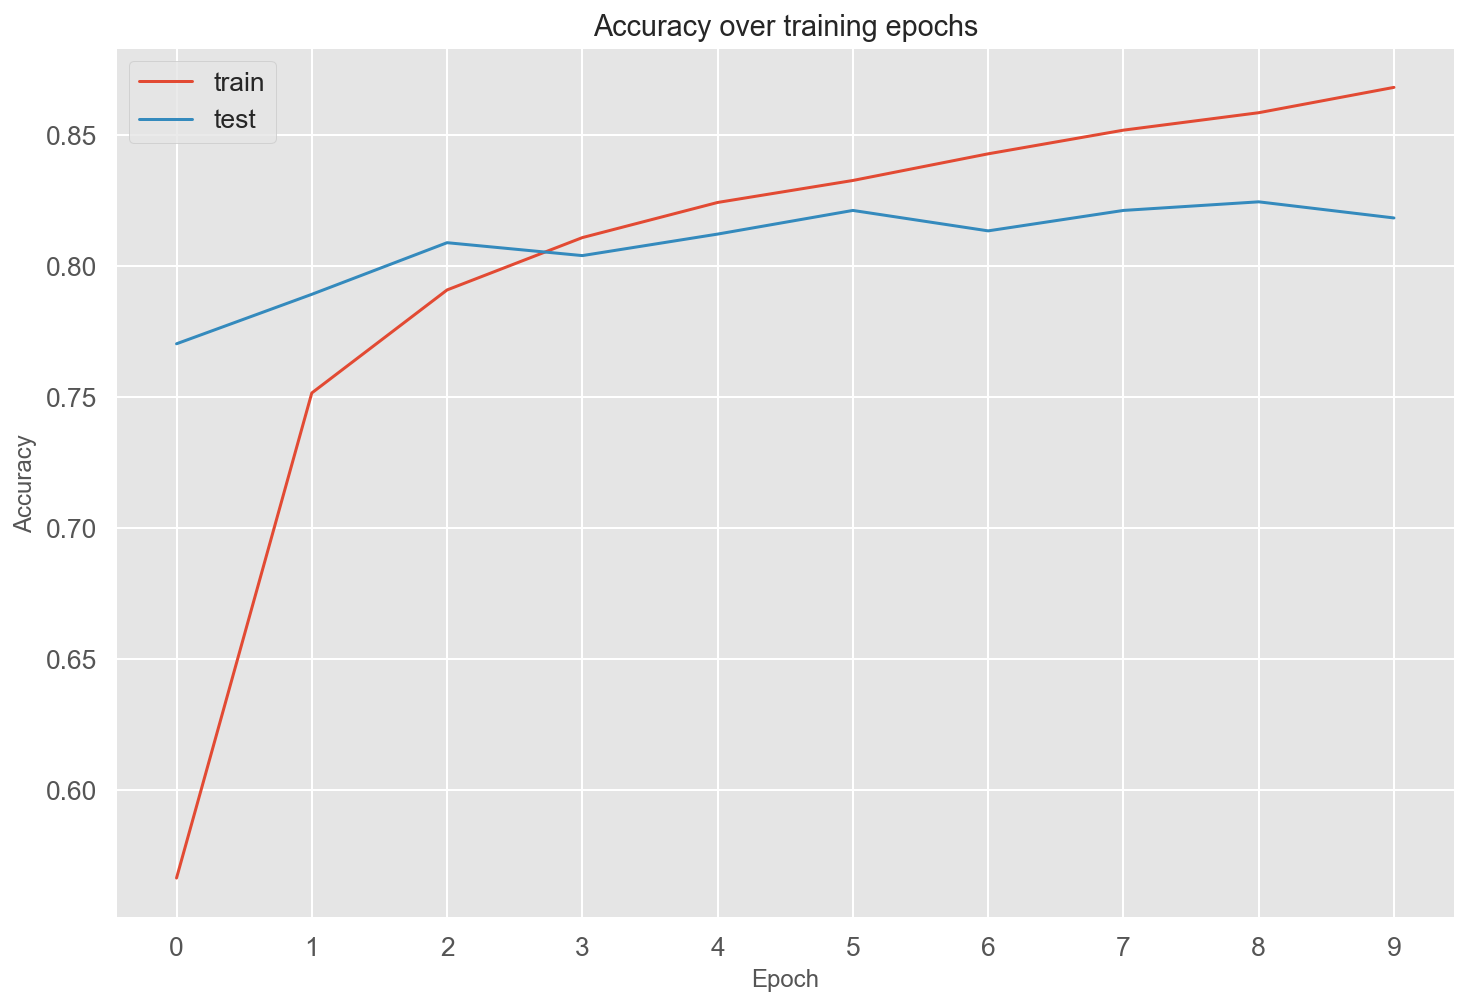

In [93]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')

In [94]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)
print(Fore.RED + "train acc", train_acc)
print(Fore.BLUE + "test acc", test_acc)

375/375 [==============================] - 105s 280ms/step - loss: 1.4840 - acc: 0.7891
train acc 0.8713887333869934
test acc 0.7890781760215759


In [95]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [96]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                          precision    recall  f1-score   support

      Cabernet Sauvignon       0.83      0.62      0.71      1747
                   Syrah       0.57      0.71      0.63       782
                Riesling       0.86      0.91      0.88       927
              Chardonnay       0.91      0.83      0.87      2190
              Pinot Noir       0.85      0.78      0.81      2490
         Sauvignon Blanc       0.70      0.84      0.77       949
Bordeaux-style Red Blend       0.79      0.84      0.82      1279
               Red Blend       0.69      0.83      0.75      1612

                accuracy                           0.79     11976
               macro avg       0.78      0.80      0.78     11976
            weighted avg       0.80      0.79      0.79     11976



In [97]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

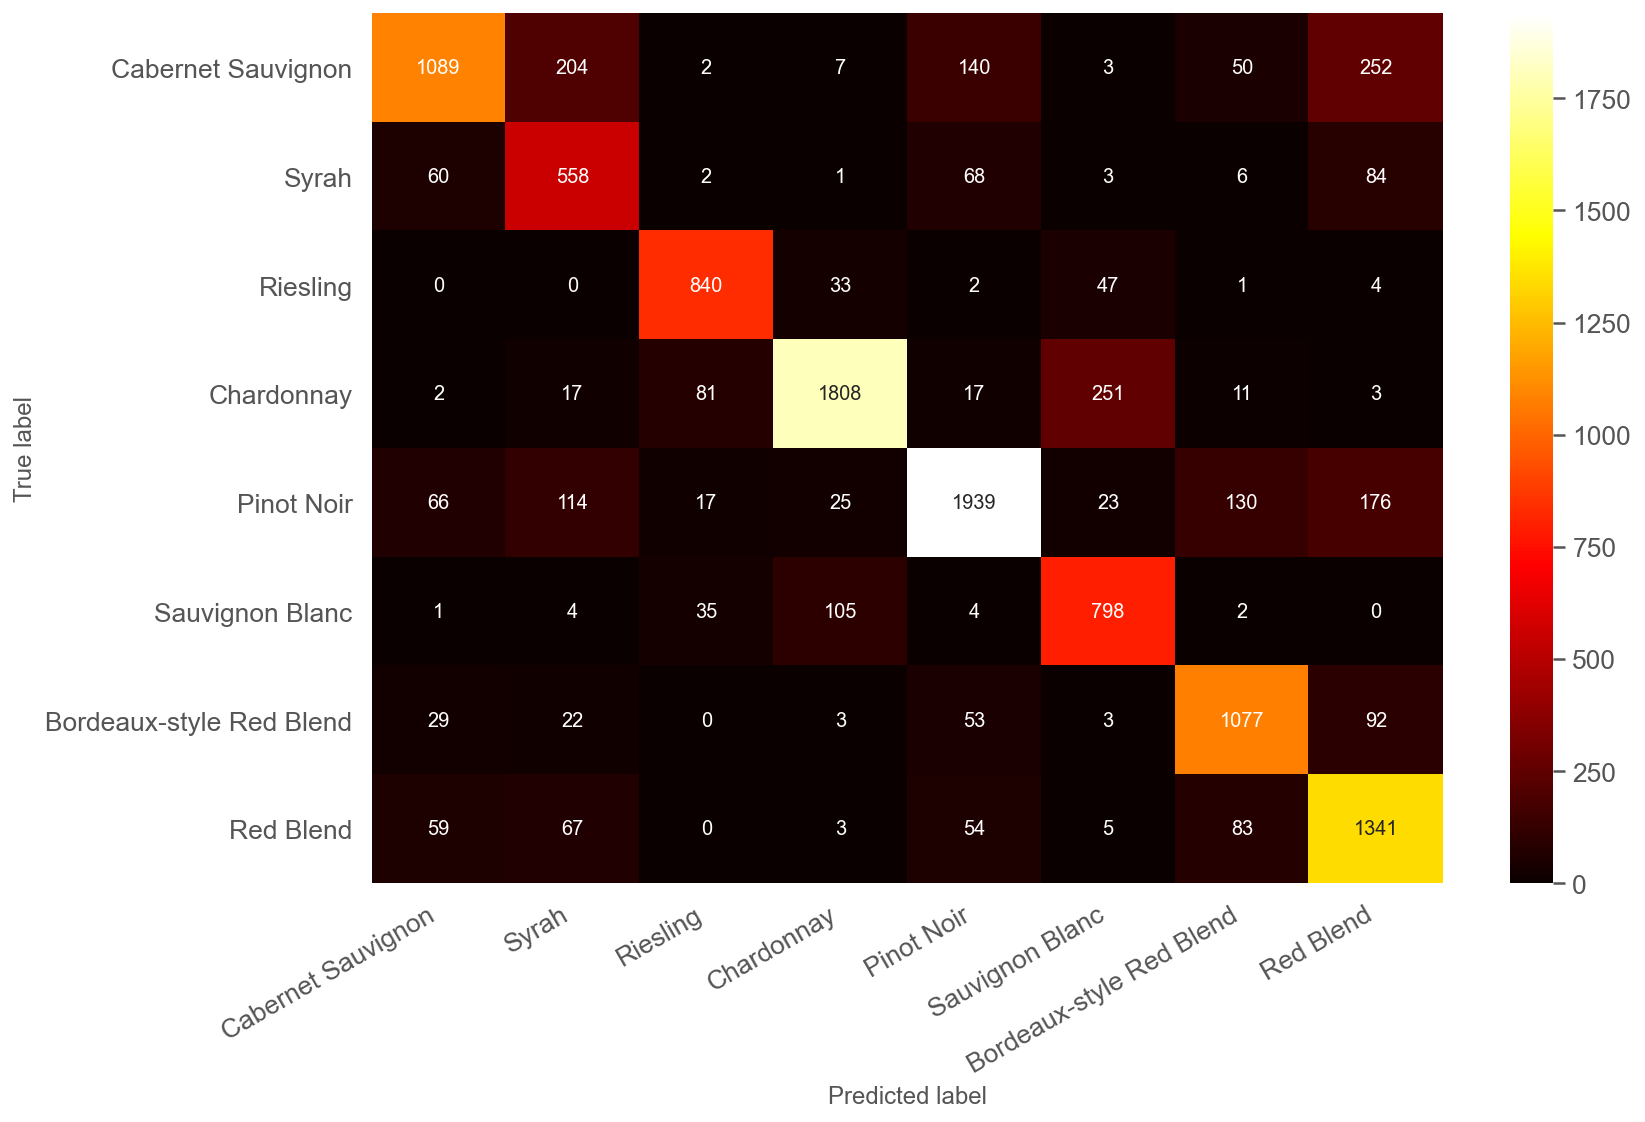

In [98]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='hot')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [100]:
sentences = [
  "Strong wine made of red grapes",
  "Grapy plummy lemon and juicy taste"
]
pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))
predictions = model.predict(pred_token_ids).argmax(axis=-1)
for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()

text: Strong wine made of red grapes 
intent: Bordeaux-style Red Blend

text: Grapy plummy lemon and juicy taste 
intent: Sauvignon Blanc



In [101]:
file = open('./weights.txt', 'w')  # 参数提取
for v in tqdm(model.trainable_variables):
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 177.63it/s]


In [113]:
pd.DataFrame(data.train_x)

0      1     2      3      4      5      6      7      8      9    ...  \
0      101  10964  2011   1046   2140  15453  10179   7869   1012    102  ...   
1      101  10964  2011   7006   7150   3915   1012    102      0      0  ...   
2      101   3319  2025   2800   2012   2023   2051   1012    102      0  ...   
3      101   3319  3793   2025   2800   2012   2023   2051   1012    102  ...   
4      101   1037  2200   3722  25869   5280  16741   2007  14768   6207  ...   
...    ...    ...   ...    ...    ...    ...    ...    ...    ...    ...  ...   
24363  101   1037  3543   1997  13493   2100   7312   2145  17991   2058  ...   
24364  101   1037  2132   2100  28693   1997  25933  10270   2072  14380  ...   
24365  101   2023  4511   4830  17644   2015   2007  15401   1012  23184  ...   
24366  101   4511  8571  17885  28315   8197   2290   7545  25353  10404  ...   
24367  101   2069  5345   3572   2020   2081   1997   2023  16384   1011  ...   

         118   119    120    121    122    123    124   125  126  127  
0          0     0      0      0      0      0      0     0    0    0  
1          0     0      0      0      0      0      0     0    0    0  
2          0     0      0      0      0      0      0     0    0    0  
3          0     0      0      0      0      0      0     0    0    0  
4          0     0      0      0      0      0      0     0    0    0  
...      ...   ...    ...    ...    ...    ...    ...   ...  ...  ...  
24363  19636  2618   1012   2023   2003   9657   1998  2969    0    0  
24364   1996  3926   2003   5423   1011  21526   2075  1012    0    0  
24365  12888  1997   9092  11483   2015   1010  22466  3070    0    0  
24366   2531  1003   2047   6116  13826   1012   2023  2003    0    0  
24367   2015  1998  21522  17688   1012   1996  14412  3686    0    0  

[24368 rows x 128 columns]

In [114]:
pd.DataFrame(data.train_y)

0
0      5
1      5
2      2
3      2
4      3
...   ..
24363  2
24364  2
24365  6
24366  1
24367  6

[24368 rows x 1 columns]

In [136]:
df["description"] 

3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
10        Soft, supple plum envelopes an oaky structure ...
12        Slightly reduced, this wine offers a chalky, t...
14        Building on 150 years and six generations of w...
                                ...                        
129958    This blend of Cabernet Sauvignon-Merlot and Ca...
129960    Fresh and fruity, this is full of red cherry f...
129963    A bouquet of black cherry, tart cranberry and ...
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
Name: description, Length: 59876, dtype: object